# Exploratory Data Analysis (EDA)

## Libraries imports and Data Loading
---
Firstly, essential libraries are imported:
- sys
- os
- pandas for tabular datata, 
- numpy for calculations on arrays and vectors, 
- matplotlib for creating graphs, 
- seaborn for more advanced graphs (e.g. heatmap or pairplot),
- and custom functions.

Also `mutual_info_classif` function from sklearn library is imported for mutual information calculation and `LabelEncoder` for encoding categorical data.

In the next step the default style for the charts appearance is set. Then, the dataset for UCI Heart Disease is loaded into a pandas DataFrame. To get initial brief overview of the columns, datatypes and sample values, first 5 rows are displayed.



In [1]:

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from scripts.utils import (
    plot_index_column_relation, 
    calculate_skewness,
    plot_histograms_with_kde,
    plot_violins,
    print_unique_values,
    plot_pairplot_with_hue,
    compute_mutual_info,
    plot_mutual_info,
    plot_class_distribution)
from scripts.cleaning.pipeline import clean_dataframe

sns.set(style="whitegrid")
%matplotlib inline


In [2]:
df = pd.read_csv("../data/heart.csv")
df.head()

id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0

From this small sample of the dataset, we can assume that there is unique identifier for each row. Moreover, some imbalance in the dataset is possible - for 5 instances, there are 5 `Males` and only one `Female`. 
However, both thesis require evaluation.

### Dot Sample Method
Dot sample method was used to randomly select a subset of the data. This method is useful due to the fact that the data might have been somehow ordered or grouped, which could lead to biased results if the data were selected in a non-random manner.


In [3]:
df.sample(3, random_state=13)

id  age   sex  dataset            cp  trestbps   chol    fbs restecg  \
565  566   52  Male  Hungary  asymptomatic     130.0  298.0  False  normal   
497  498   38  Male  Hungary  asymptomatic     110.0  196.0  False  normal   
320  321   36  Male  Hungary   non-anginal     112.0  340.0  False  normal   

     thalch  exang  oldpeak slope  ca    thal  num  
565   110.0   True      1.0  flat NaN     NaN    1  
497   166.0  False      0.0   NaN NaN     NaN    1  
320   184.0  False      1.0  flat NaN  normal    0

Once again the number of `Males` dominates over the number of `Females`. In this case ratio of `Males` to `Females` is 3:0. 
Besides this, it can be noticed that even young adults with normal ranges of ECG and blood sugar suffer from heart diseases.
Moreover, significant data is missing for those rows - such as: `ca`, `thal`, `slope` which may suggest that the dataset from Hungary differs in completeness from the one from Cleveland.

## Before Data Cleaning
---

### Shape and Size of Dataset


In [4]:
print("Shape:", df.shape)
print("Records (rows):", df.shape[0])
print("Features (columns):", df.shape[1])

Shape: (920, 16)
Records (rows): 920
Features (columns): 16


The most basic information regarding the dataset is its shape. In this case we are dealing with moderate dataset with 16 features (columns) and 920 records (rows).

### Data Types
In this step it is investigated what type of data is used.

In [5]:
df.dtypes

id            int64
age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
num           int64
dtype: object

#### Null Values

In [6]:
null_percentage = df.isnull().mean() * 100
print(null_percentage.sort_values(ascending=False))

ca          66.413043
thal        52.826087
slope       33.586957
fbs          9.782609
oldpeak      6.739130
trestbps     6.413043
exang        5.978261
thalch       5.978261
chol         3.260870
restecg      0.217391
cp           0.000000
dataset      0.000000
id           0.000000
age          0.000000
sex          0.000000
num          0.000000
dtype: float64


We can notice that `ca` which stands for `number of major vessels` and `thal` which is `abnormality in heart function` present over 50% of null values.

#### Categorical vs Numerical Columns
Later dataset is checked under the condition of categorical vs numerical data types.

In [7]:
numerical_columns = df.select_dtypes(include=np.number).columns.to_list()
categorical_columns = df.select_dtypes(exclude=np.number).columns.to_list()

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)


Numerical columns: ['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'num']
Categorical columns: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


One can notice that many columns belong to categorical which later require encoding.

##### Statistical Description of Numerical Columns 

In [8]:
df[numerical_columns].describe()

id         age    trestbps        chol      thalch     oldpeak  \
count  920.000000  920.000000  861.000000  890.000000  865.000000  858.000000   
mean   460.500000   53.510870  132.132404  199.130337  137.545665    0.878788   
std    265.725422    9.424685   19.066070  110.780810   25.926276    1.091226   
min      1.000000   28.000000    0.000000    0.000000   60.000000   -2.600000   
25%    230.750000   47.000000  120.000000  175.000000  120.000000    0.000000   
50%    460.500000   54.000000  130.000000  223.000000  140.000000    0.500000   
75%    690.250000   60.000000  140.000000  268.000000  157.000000    1.500000   
max    920.000000   77.000000  200.000000  603.000000  202.000000    6.200000   

               ca         num  
count  309.000000  920.000000  
mean     0.676375    0.995652  
std      0.935653    1.142693  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    1.000000  
75%      1.000000    2.000000  
max      3.000000    4.000000

`id`: stands only for the index and it is completely not useful for the data analysis. In the process of cleaning this column can be freely dropped.

`age`: we are dealing with middle-aged adults. At first glance it does not look like we were dealing with any kind of outliers.

`trestbps (resting blood pressure)`: requires data cleaning due to unusually low value.

`chol`: requires data cleaning due to unusually low and high values.

`thalch (maximum heart rate)`: consists of plausible values which may prove to be essential in the estimation of fitness.

`oldpeak (ST depression)`: requires data cleaining due negative = impossible values.

`ca (number of vessels colored)`: significant number of missing values, however important feature for the analysis.

`num (presence of heart disease)`: multiclass format, instead of binary. Requires invsetigation for data imbalance (data skews towards lower classes).

##### Statistical Description of Categorical Columns 

In [9]:
if categorical_columns:
    display(df[categorical_columns].describe())
else:
    print("No categorical columns to describe")

sex    dataset            cp    fbs restecg  exang slope    thal
count    920        920           920    830     918    865   611     434
unique     2          4             4      2       3      2     3       3
top     Male  Cleveland  asymptomatic  False  normal  False  flat  normal
freq     726        304           496    692     551    528   345     196

`sex`: the initial assumption regarding data impalance is met, as the number of males is significantly different than number of females (males constitute 79%).

`dataset`: data comes from different sources, which may result in inconsistent data.

`cp (chest pain type)`: this feature is most likely to be highly predictive for heart diseases. However, most patients do not experience obvious symptoms.

`fbs (fasting blood sugar > 120 mg/d)`: majority has normal sugar levels.

`restecg (resting ECG)`: majority has normal electrocardiogram.

`exang (exercise-induced angina)`: majority does not experience angina during exercise.

`slope (slope of ST segment during excercise)`: flat value is most common. This feature is known to be clinical predictor of ischemia.

`thal (Thallium stress test result)`: many missing values, however clinically significant.

### Index vs Numerical Columns
 

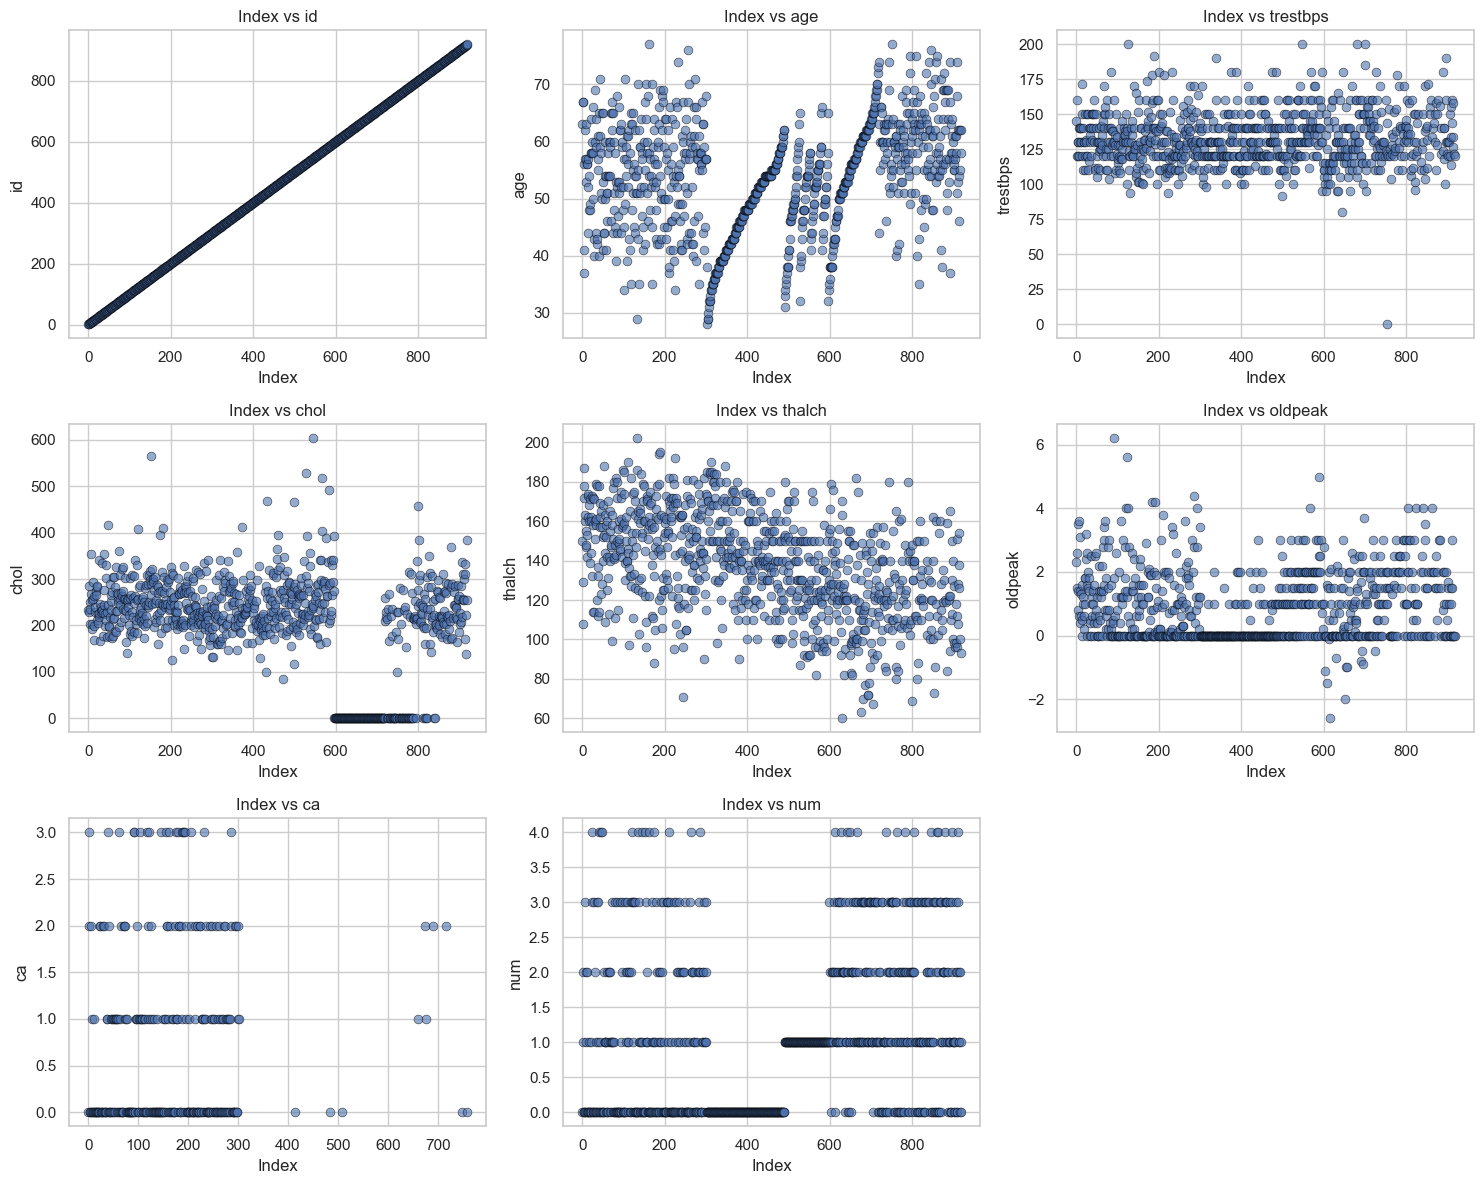

In [10]:
plot_index_column_relation(df)

Plot `Index vs id` confirms that dataset is ordered by `id` and the column will be redundant in data analysis.

An interesting phenomenon may be observed on the plot `Index vs age` where some points appear to be ordered. It may occur due to the fact that dataset consists of smaller datasets from different locations, and for some locations, the data is ordered by `age`. Moreover, some sources has data of younger patients than others.

`Index vs trestbps` indicates some outliers on too low values. Similarly does `Index vs chol` where value below 40 is most probably data mistake.

`Index vs oldpeak` presents domination of values in the range between 0 and 3, however, there are some outliers as the oldpeak cannot be below 0.

Many missing rows can be noticed in the plot `Index vs ca`. Range of values is as expected which indicates no outliers.

`Index vs num` indicates that some segments of the data are dominated by a specific class of heart disease label - it can be also due to source of dataset. 

### Skewness Analysis
Skewness quantifies the asymmetry of numerical feature distributions.


In [11]:
calculate_skewness(df)

Feature  Skewness                Skew Type
0        ca  1.165978             Right-skewed
1   oldpeak  1.041427             Right-skewed
2       num  0.968880             Right-skewed
3      chol -0.613836              Left-skewed
4  trestbps  0.213334  Approximately symmetric
5    thalch -0.211119  Approximately symmetric
6       age -0.195994  Approximately symmetric
7        id  0.000000  Approximately symmetric

- A skewness ≈ 0 indicates a roughly symmetric distribution.  
- A positive skew indicates a long tail to the right.  
- A negative skew indicates a long tail to the left.  

### Violin Plots of Numerical Features

The following violin plots visualize the distribution and spread of all numerical features. These are especially useful after assessing skewness, as they reveal outliers, multimodal distributions, and symmetry in the data.


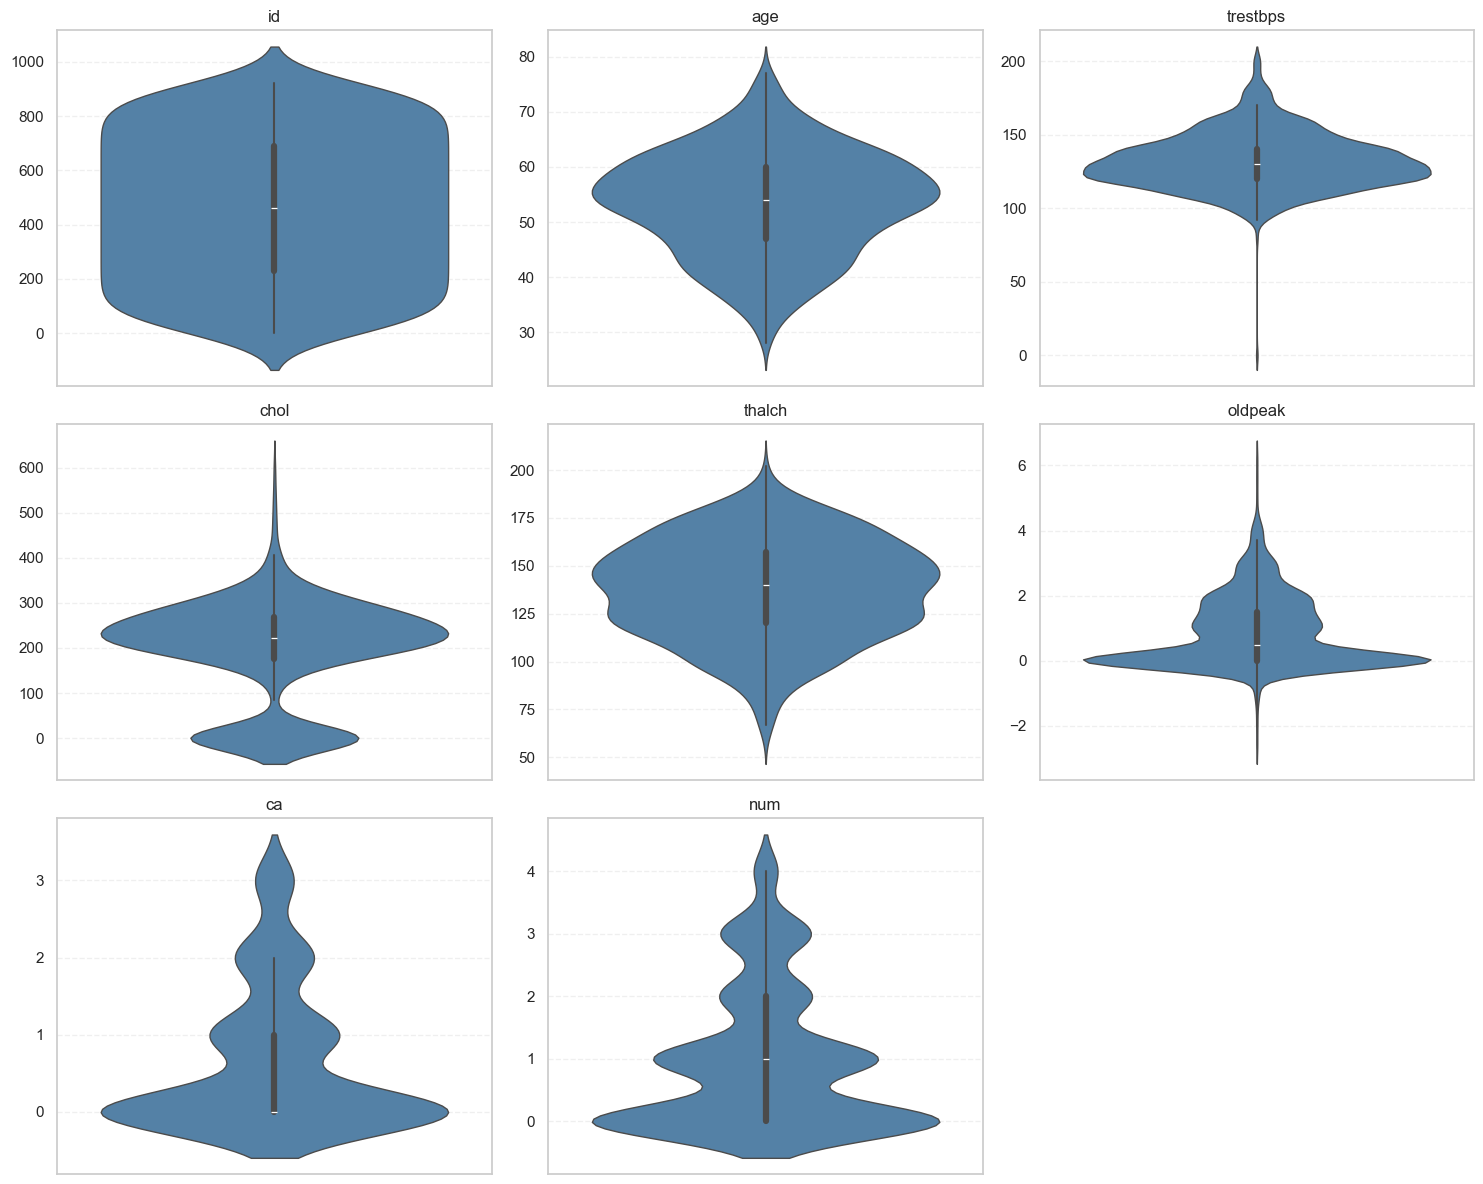

In [12]:
plot_violins(df)

`trestbps`: Invalid values at 0 (physiologically invalid). Should be cleaned.

`chol`: Extreme outliers (≥500 mg/dL) suggest possible data entry errors. Also contains 0, which is invalid. Should be cleaned.

`oldpeak`: Long tail and values < 0 (physiologically invalid). Should be cleaned.

### Histogram Frequency
This plot is used to represent the distribution of data, which shows how often it occurs.

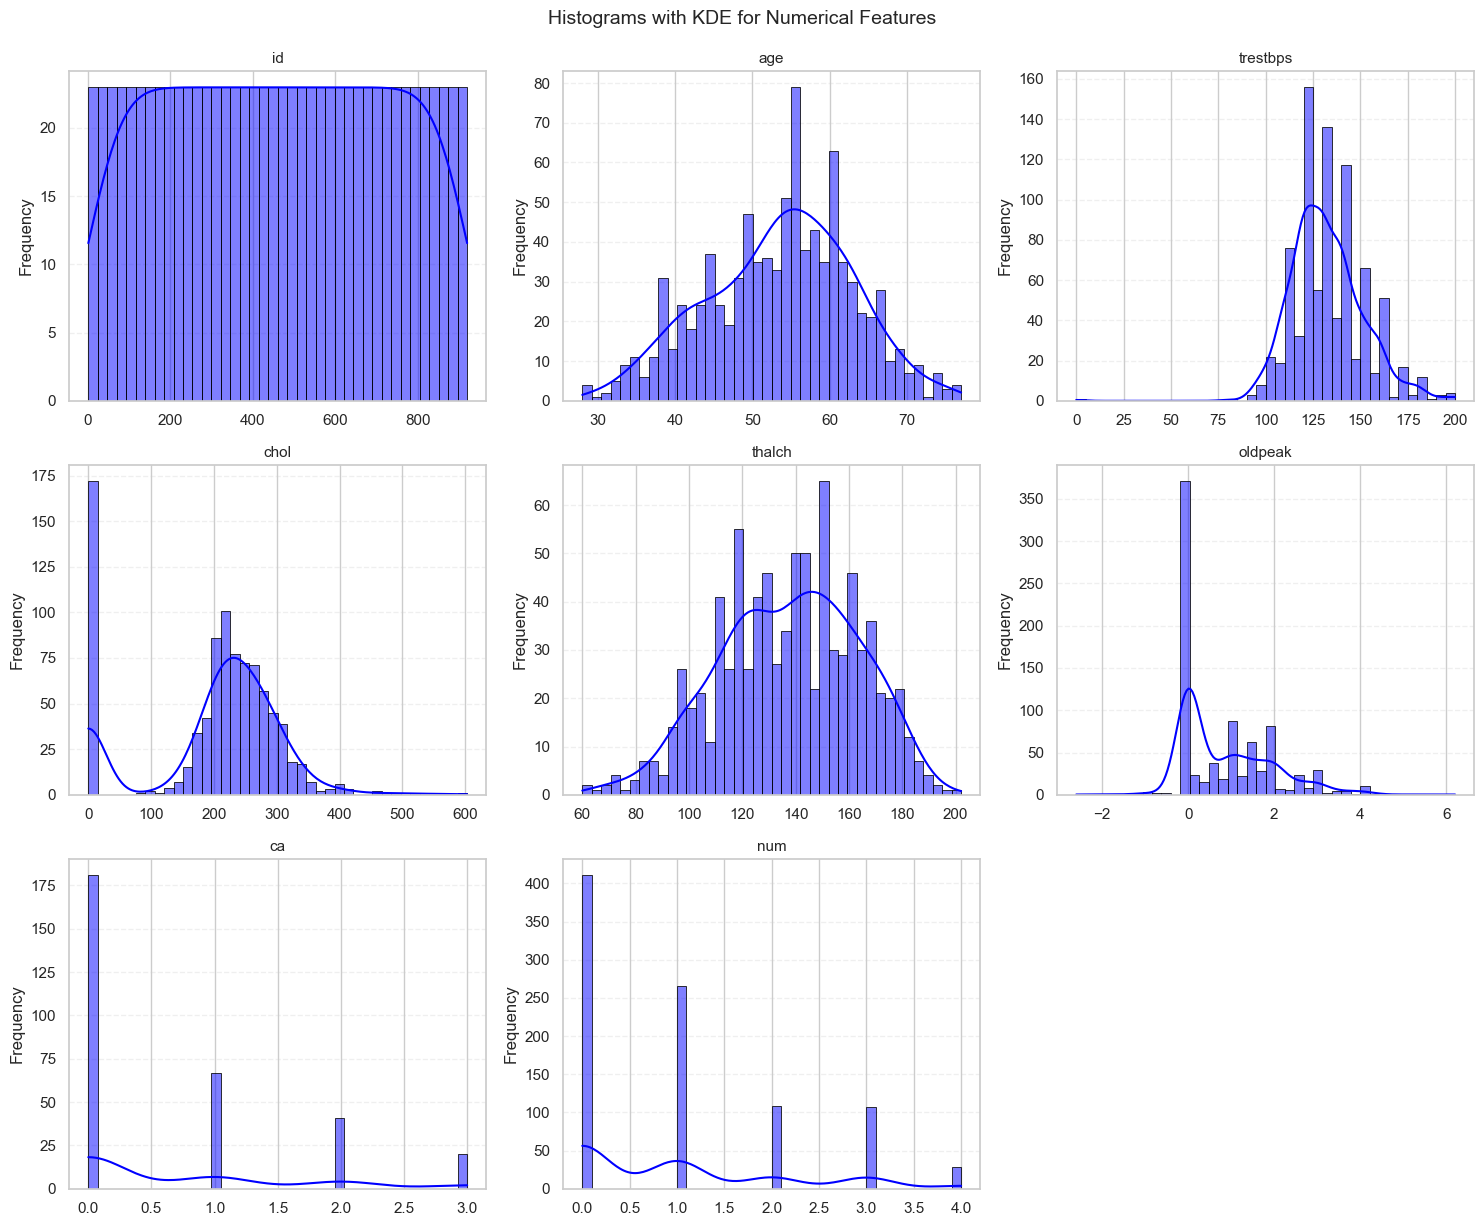

In [13]:
plot_histograms_with_kde(df)

As expected `id` should not be taken into consideration in data modeling.

Feature `age` roughly shows normal distribution with a peak between 50 and 60. This indicates that the majority of patients are middle-aged or slightly older.

Most values of `trestbps` are between the expected range and the distribution appears to be right-skewed.

With `chol` very specific spike can be noticed at value 0 - which must have been chosen as placeholder for missing values. The remaining values are right-skewed.

The histogram of `thalch` resembles normal distribution with no extreme outliers visible.

`Oldpeak` shows high spike at value 0, which is again a placeholder for missing values, since they are not physiologically possible. 

Number of major vessels colored by fluoroscopy `ca` is represented by discrete values from 0 to 3. The highest concentration is at values 0 and 1 with visible imbalance.

Heart Disease Class - `num` is represented by discrete values from 0 to 4. Most values are concentrated at 0 and 1 with visible imbalance.



### Correlation of Columns
By verifing the correlation, the similarity between the columns can be determined.

#### Correlation Heatmap

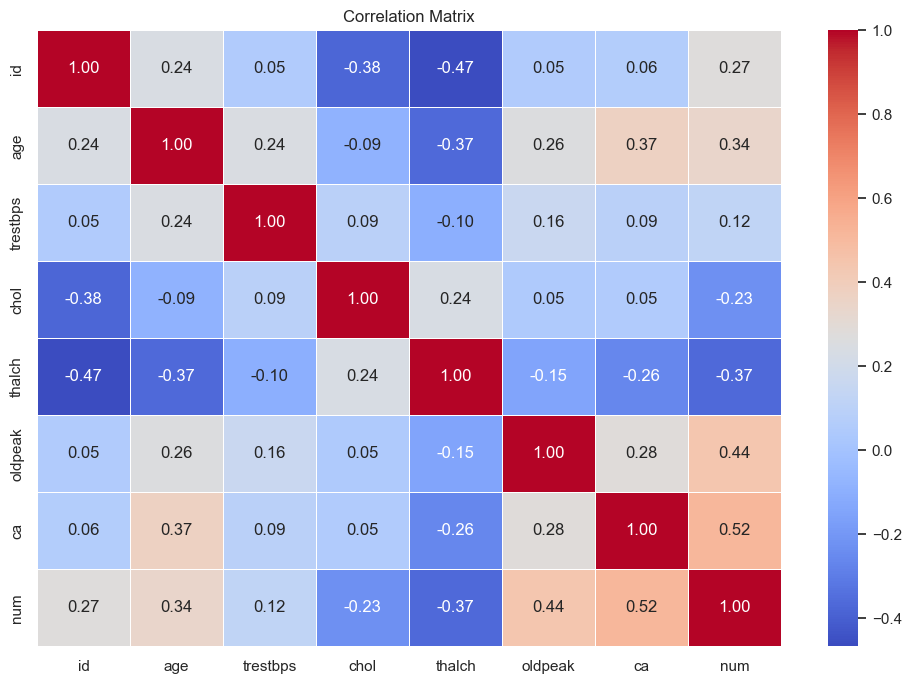

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_columns].corr(), annot=True, linewidth=.5, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

| Variable Pair     | Correlation | Strength | Interpretation|
|:-----------------:|:-----------:|:--------:|---------------|
| `num` vs `ca` | +0.52 | Strong positive | The more vessels, the higher likelihood of heart disease.|
| `id` vs `thalach` | -0.47 | Strong negative | ID is just a sequential number. The dataset appears to be ordered by source, so earlier patients (lower id) are younger, they tend to be healthier and are more likely to have higher max heart rate.|
| `num` vs `oldpeak` | +0.44 | Moderate positive | Higher ST depression (`oldpeak`) is connected with likelihood of heart disease.|
| `id` vs `chol` | -0.38 | Moderate negative | Again ID is just index number and the correlation is due to the ordering of the data.|
| `age` vs `ca` | +0.37 | Moderate positive | Elderly patients are more likely to have affected vessels.|
| `age` vs `thalach` | -0.37 | Moderate negative | Older patients tend ot have lower max heart rate.|
| `num` vs `thalach` | -0.37 | Moderate negative | Lower max heart rate increases likelihood of heart disease.|
| `num` vs `age` | +0.34 | Moderate positive | The elderly are at greatest risk of developing heart diseases.|
| `ca` vs `oldpeak` | +0.28 | Weak-to-moderate positive | The greater number of major vesselsm, the higher is the ST depression.|
| `num` vs `id` | +0.27 | Weak positive | ID is not a valid feature and not related to prediction.|
| `age` vs `oldpeak` | +0.26 | Weak positive | Older individuals show slightly higher ST depression.|
| `ca` vs `thalach` | -0.26 | Weak negative | The higher number of vessels, the lower is max heart rate.|


In [15]:
df.corr(numeric_only=True)


id       age  trestbps      chol    thalch   oldpeak  \
id        1.000000  0.239301  0.052924 -0.376936 -0.466427  0.049930   
age       0.239301  1.000000  0.244253 -0.086234 -0.365778  0.258243   
trestbps  0.052924  0.244253  1.000000  0.092853 -0.104899  0.161908   
chol     -0.376936 -0.086234  0.092853  1.000000  0.236121  0.047734   
thalch   -0.466427 -0.365778 -0.104899  0.236121  1.000000 -0.151174   
oldpeak   0.049930  0.258243  0.161908  0.047734 -0.151174  1.000000   
ca        0.061433  0.370416  0.093705  0.051606 -0.264094  0.281817   
num       0.273552  0.339596  0.122291 -0.231547 -0.366265  0.443084   

                ca       num  
id        0.061433  0.273552  
age       0.370416  0.339596  
trestbps  0.093705  0.122291  
chol      0.051606 -0.231547  
thalch   -0.264094 -0.366265  
oldpeak   0.281817  0.443084  
ca        1.000000  0.516216  
num       0.516216  1.000000

From this analysis, following some initial conclusions can be drawn.
- Column `id` can be dropped - it is purely artificial and will not be important in future steps. 
- Number of affected vessels `ca` has the strongest positive correlation with num which indicates it as a critical factor in the prediction of heart diseases.
- Response to excercise is a significant risk indicator - `oldpeak` (ST depression) and `thalach` (max heart rate) are moderately correlated with `num`.
- `Age` correlates positively with `ca`, `oldpeak`, `num`. This indicated that older patients are more likely to have more major vessels, ST depression and heart disease.

### Unique Values

In [16]:
print_unique_values(df)


Column: id
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

Analysis of numerical columns:
- `id`: It confirms again that ID is nothing else than the index of column.
- `age`: Dataset covers a wide range of ages, from 28 to 77 years old with no visible outliers.
- `trestbps`: There is many unique values, however it also includes medically invalid values at 0.0.
- `chol`: Very rich distribution, again it includes invalid values at 0.0.
- `thalch`: High variety, likely continous variable. No outliers.
- `oldpeak`: Includes negative values, which are incorrect for the ST depression metric. 
- `ca`: Discrete number of major vessels. Values in range form 0 to 3.
- `num`: Target class (heart disease severity or presence), values in range from 0 to 4.

Analysis of categorical columns:
- `sex`: Binary encoding 'Male', 'Female', however it could be encoded as 0/1.
- `dataset`: 	Origin of patient record (dataset source).
- `cp`: Categorical feature requiring label encoding.
- `fbs`: Boolean feature for fasting blood sugar (>120mg/dl = true)
- `restecg`: Results of ECG exam in 3 categories.
- `exang`: Boolean values for exercise induced angina.
- `slope`: Slope of ST segment represented by 3 categories.
- `thal`: Thalassemia condition represented by 3 categories.

### Pairplot with Hue

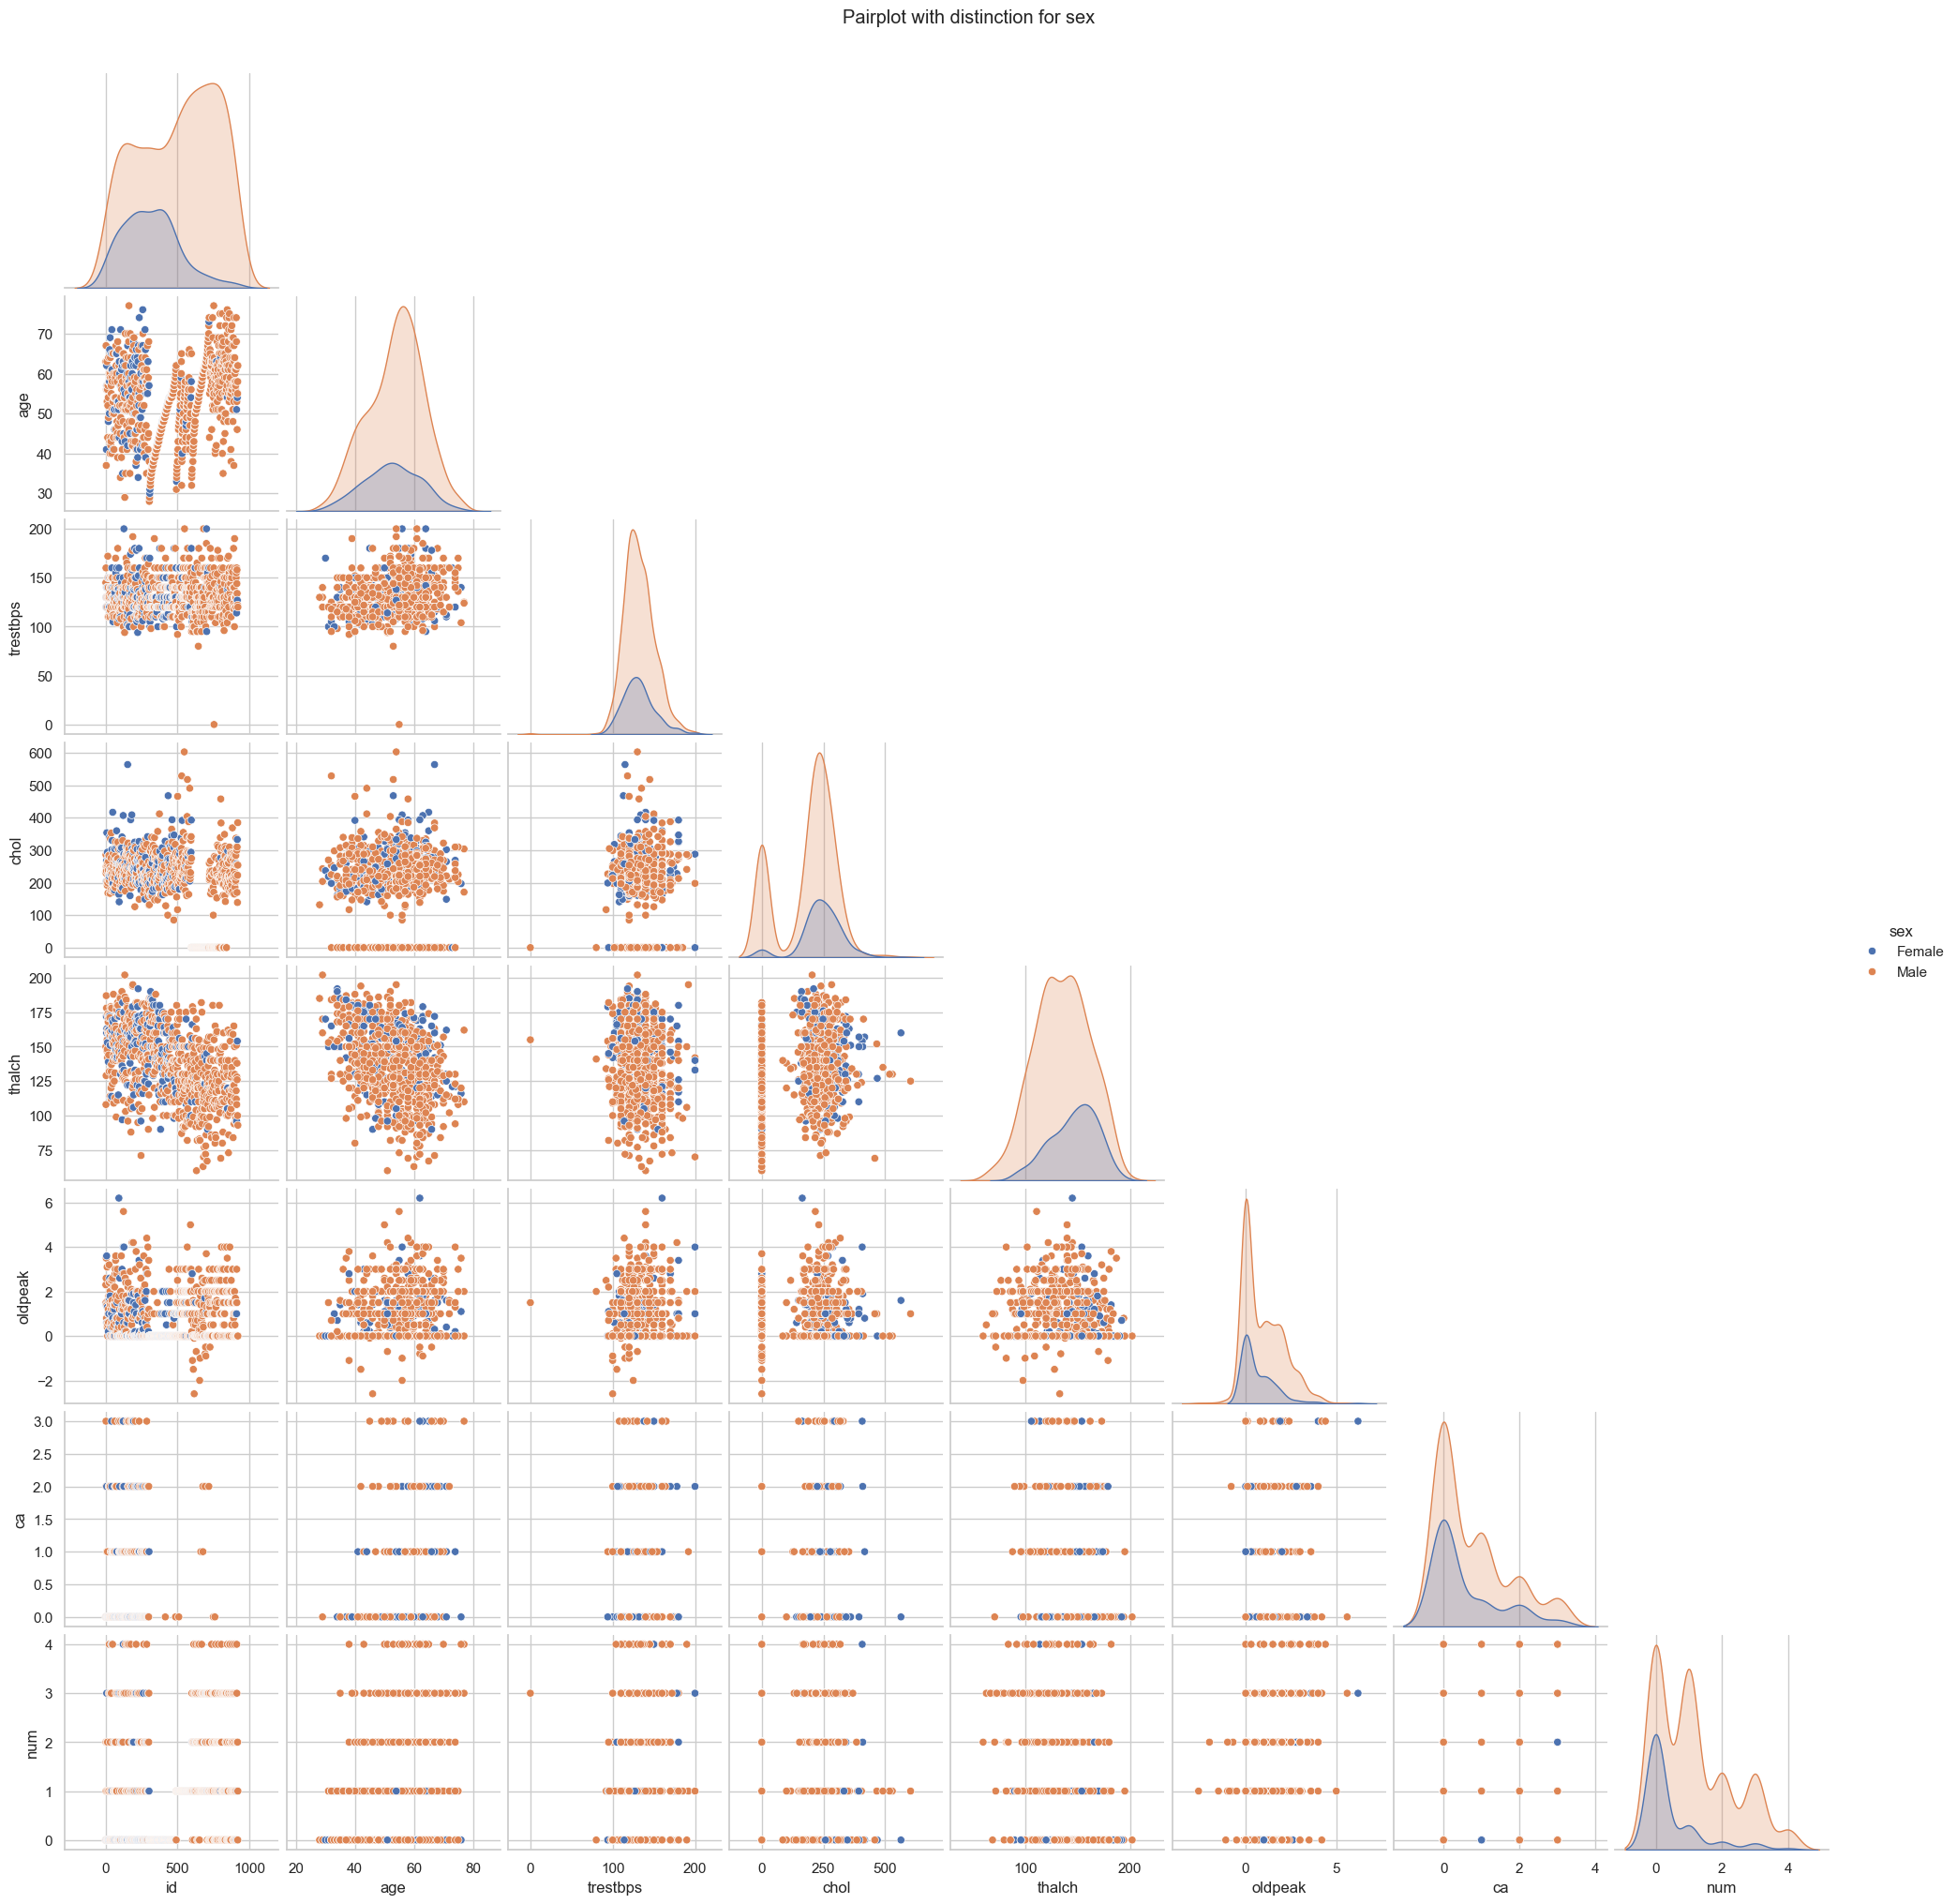

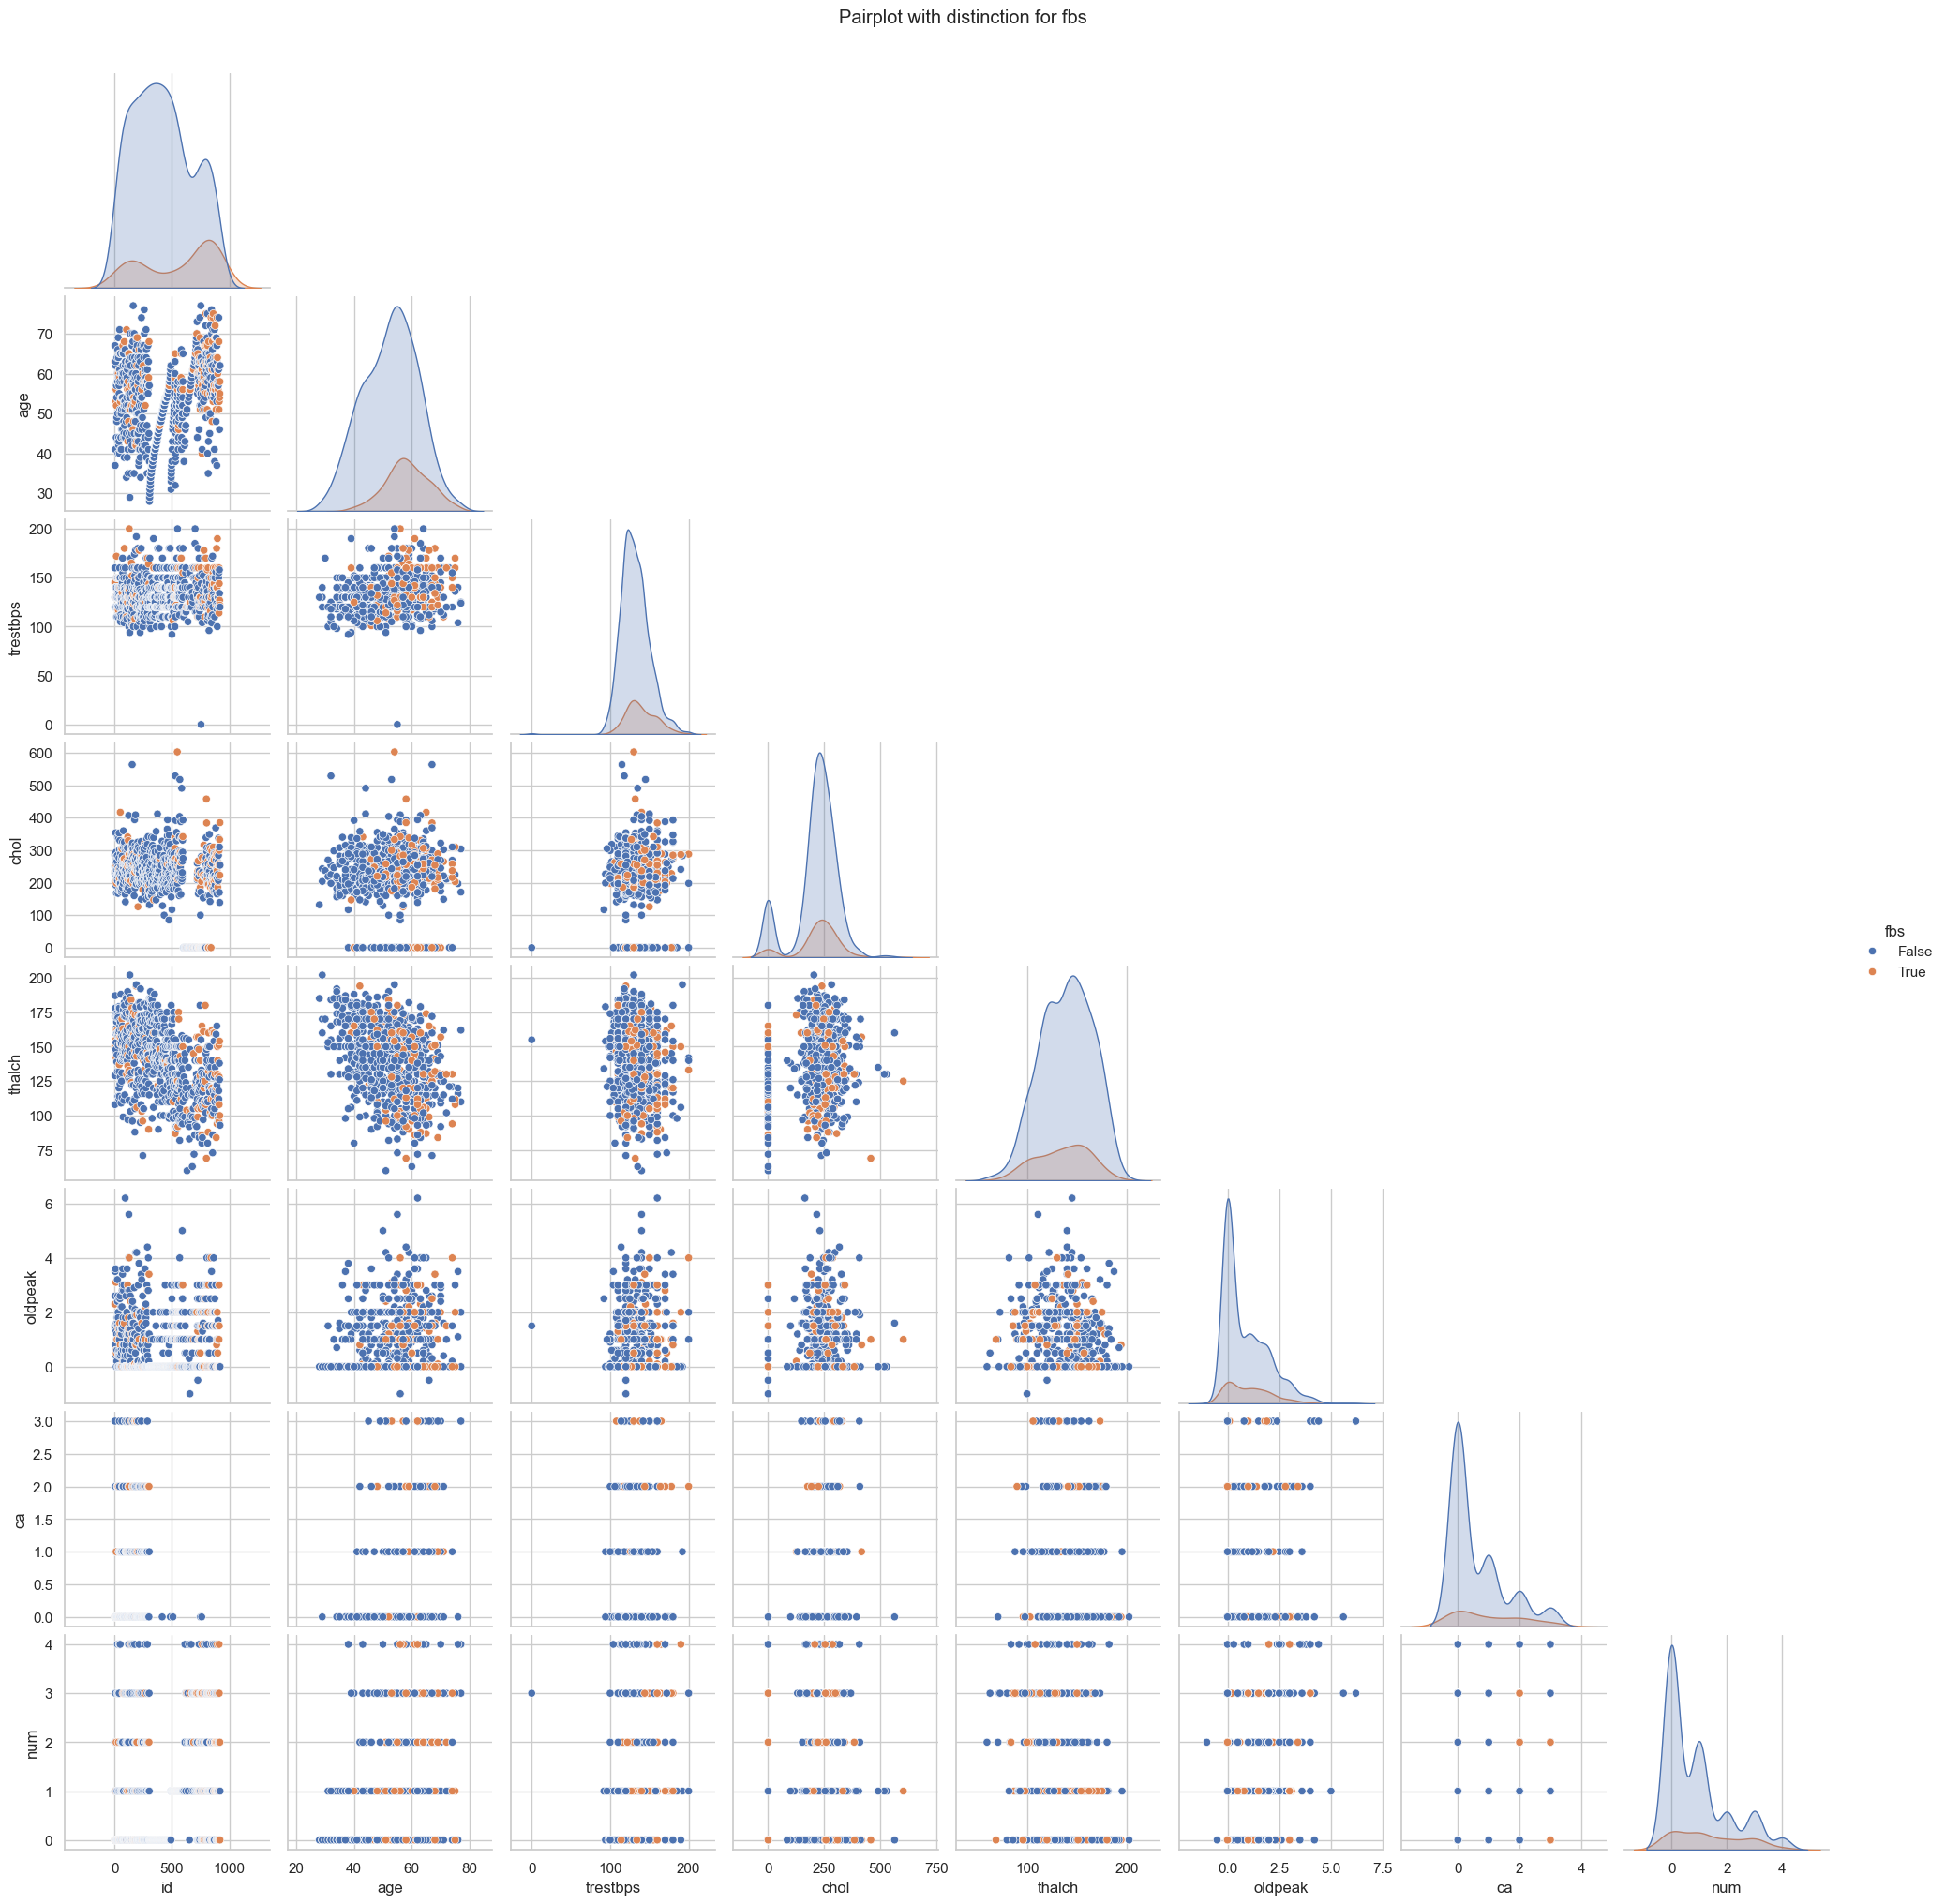

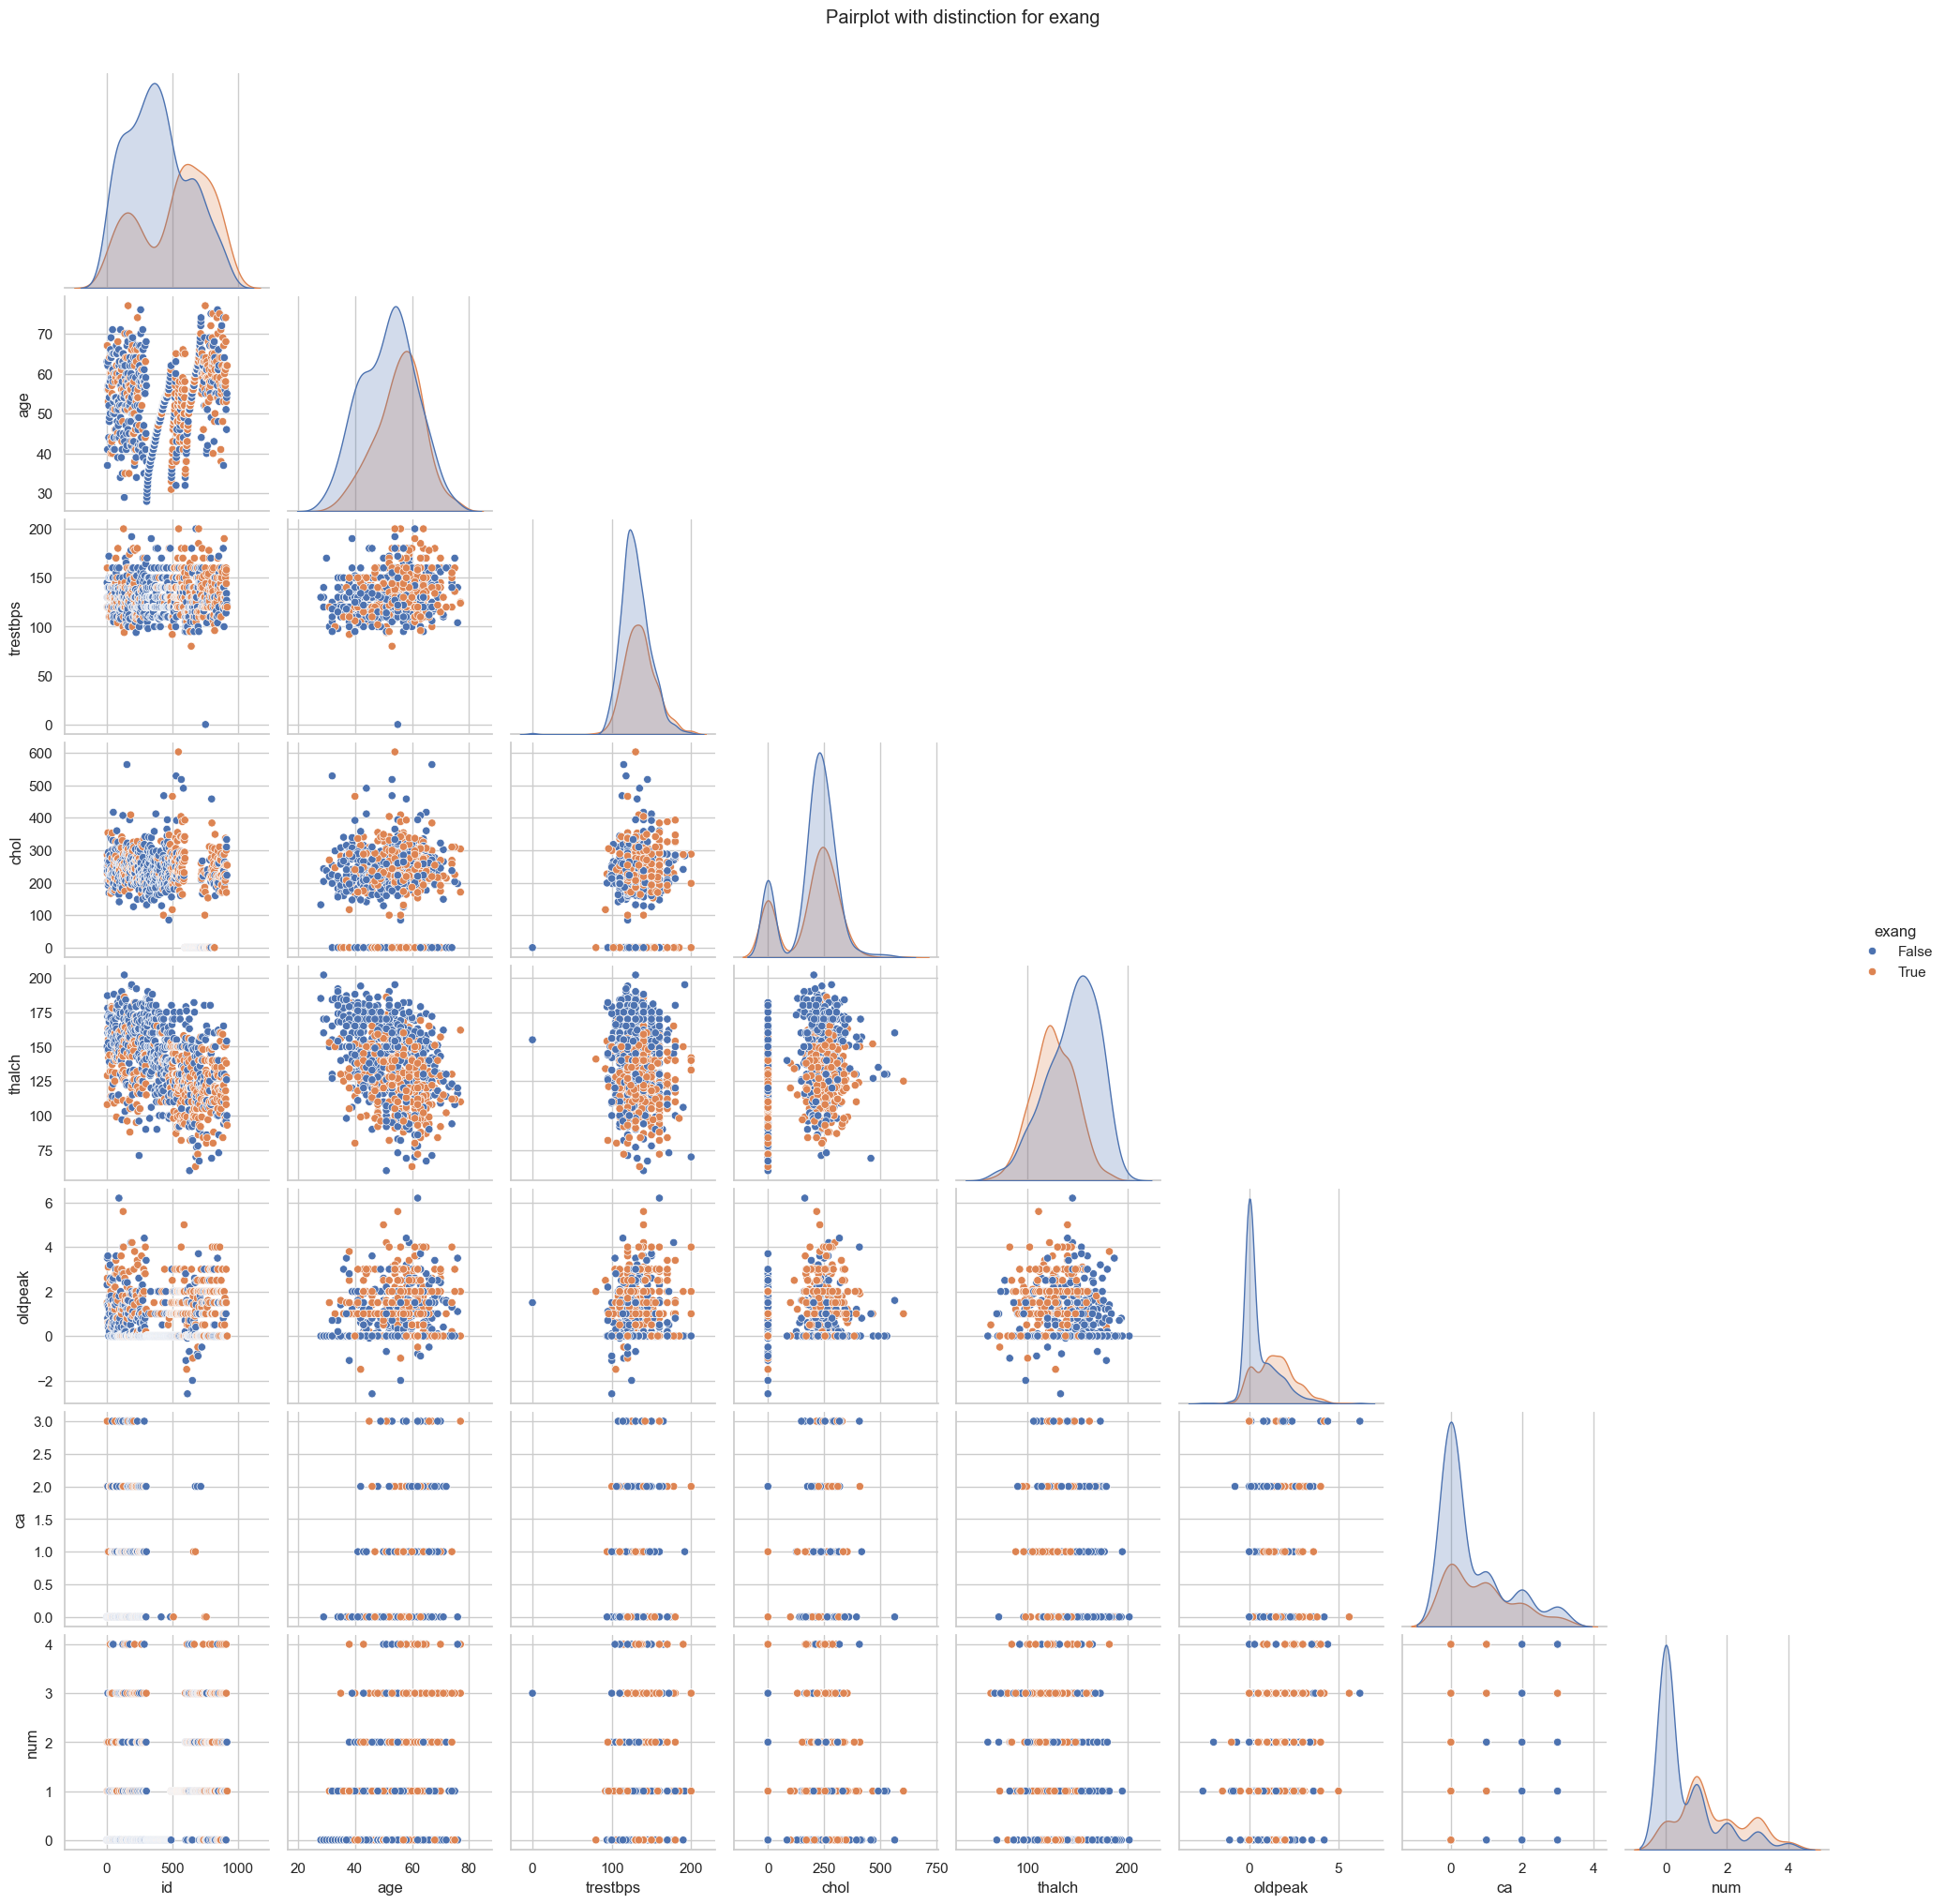

In [17]:
plot_pairplot_with_hue(df, hue_col='sex')
plot_pairplot_with_hue(df, hue_col='fbs')
plot_pairplot_with_hue(df, hue_col='exang')


Pairplot by `sex` does not present any sharp separation between males and females regarding heart disease, however it suggests confirms data imbalance male vs female.

Pairplot by `fbs` indicates very strong imbalance of records with elevated blood sugar levels vs normal  levels. There is no strong visible separation between `trestbps`, `chol`, `thalch`, or `oldpeak` and it doesnt seem to correlate strongly with num.

Pariplot with distinction by `exang` provides us with some more information - `thalch`, `oldpeak`, and `exang` together can be strong predictors of heart disease. Patients without angina tend to reach higher max heart rates.
Moreover, those with angina have higher ST depression. Also, angina is more common in patients with heart disease, have more vessels affected (ca) and are slightly older.

### Mutual Information Score
Mutual Information (MI) measures the dependency between each feature and the target variable (`num`). Unlike correlation, it can capture non-linear relationships. Higher values indicate higher predictive power.

Feature  Mutual Information
0        ca            0.110365
1   oldpeak            0.102116
2    thalch            0.083995
3        id            0.057356
4      chol            0.021153
5  trestbps            0.000000
6       age            0.000000

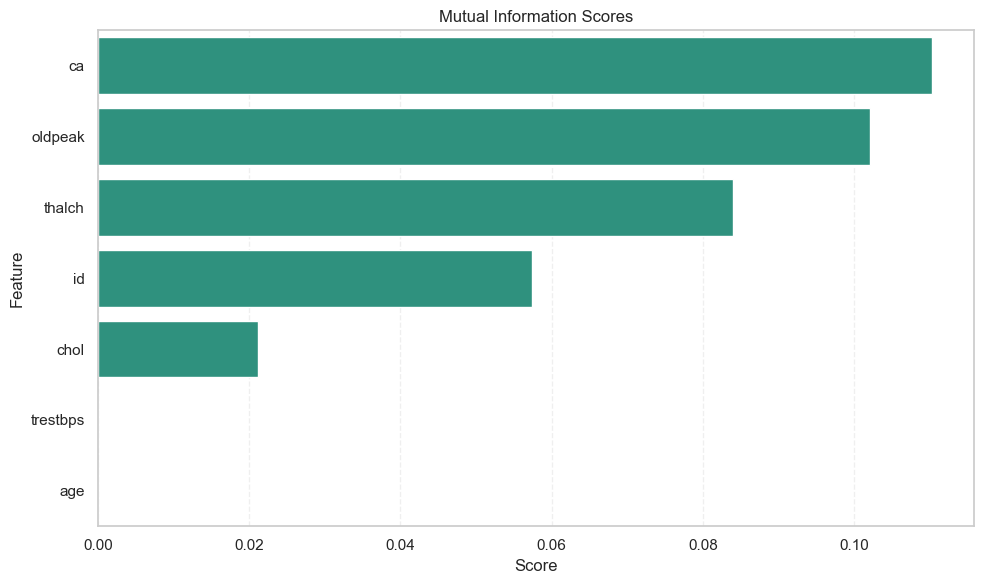

In [18]:
mi_df = compute_mutual_info(df, target_column='num')
display(mi_df)
plot_mutual_info(mi_df)

From MI we get that `ca`, `oldpeak`, and `thalch` are top predictors.

### Class Label Distribiution 

In plots of class label distribution only the categorical columns were considere with discrete numerical with few uniqe values.


Class Distribution Summary for 'sex':
| Class   |   Instances |   Percentage |
|:--------|------------:|-------------:|
| Female  |         194 |        21.09 |
| Male    |         726 |        78.91 |

Class Distribution Summary for 'dataset':
| Class         |   Instances |   Percentage |
|:--------------|------------:|-------------:|
| Cleveland     |         304 |        33.04 |
| Hungary       |         293 |        31.85 |
| Switzerland   |         123 |        13.37 |
| VA Long Beach |         200 |        21.74 |

Class Distribution Summary for 'cp':
| Class           |   Instances |   Percentage |
|:----------------|------------:|-------------:|
| asymptomatic    |         496 |        53.91 |
| atypical angina |         174 |        18.91 |
| non-anginal     |         204 |        22.17 |
| typical angina  |          46 |         5.00 |

Class Distribution Summary for 'fbs':
| Class   |   Instances |   Percentage |
|:--------|------------:|-------------:|
| False   |        

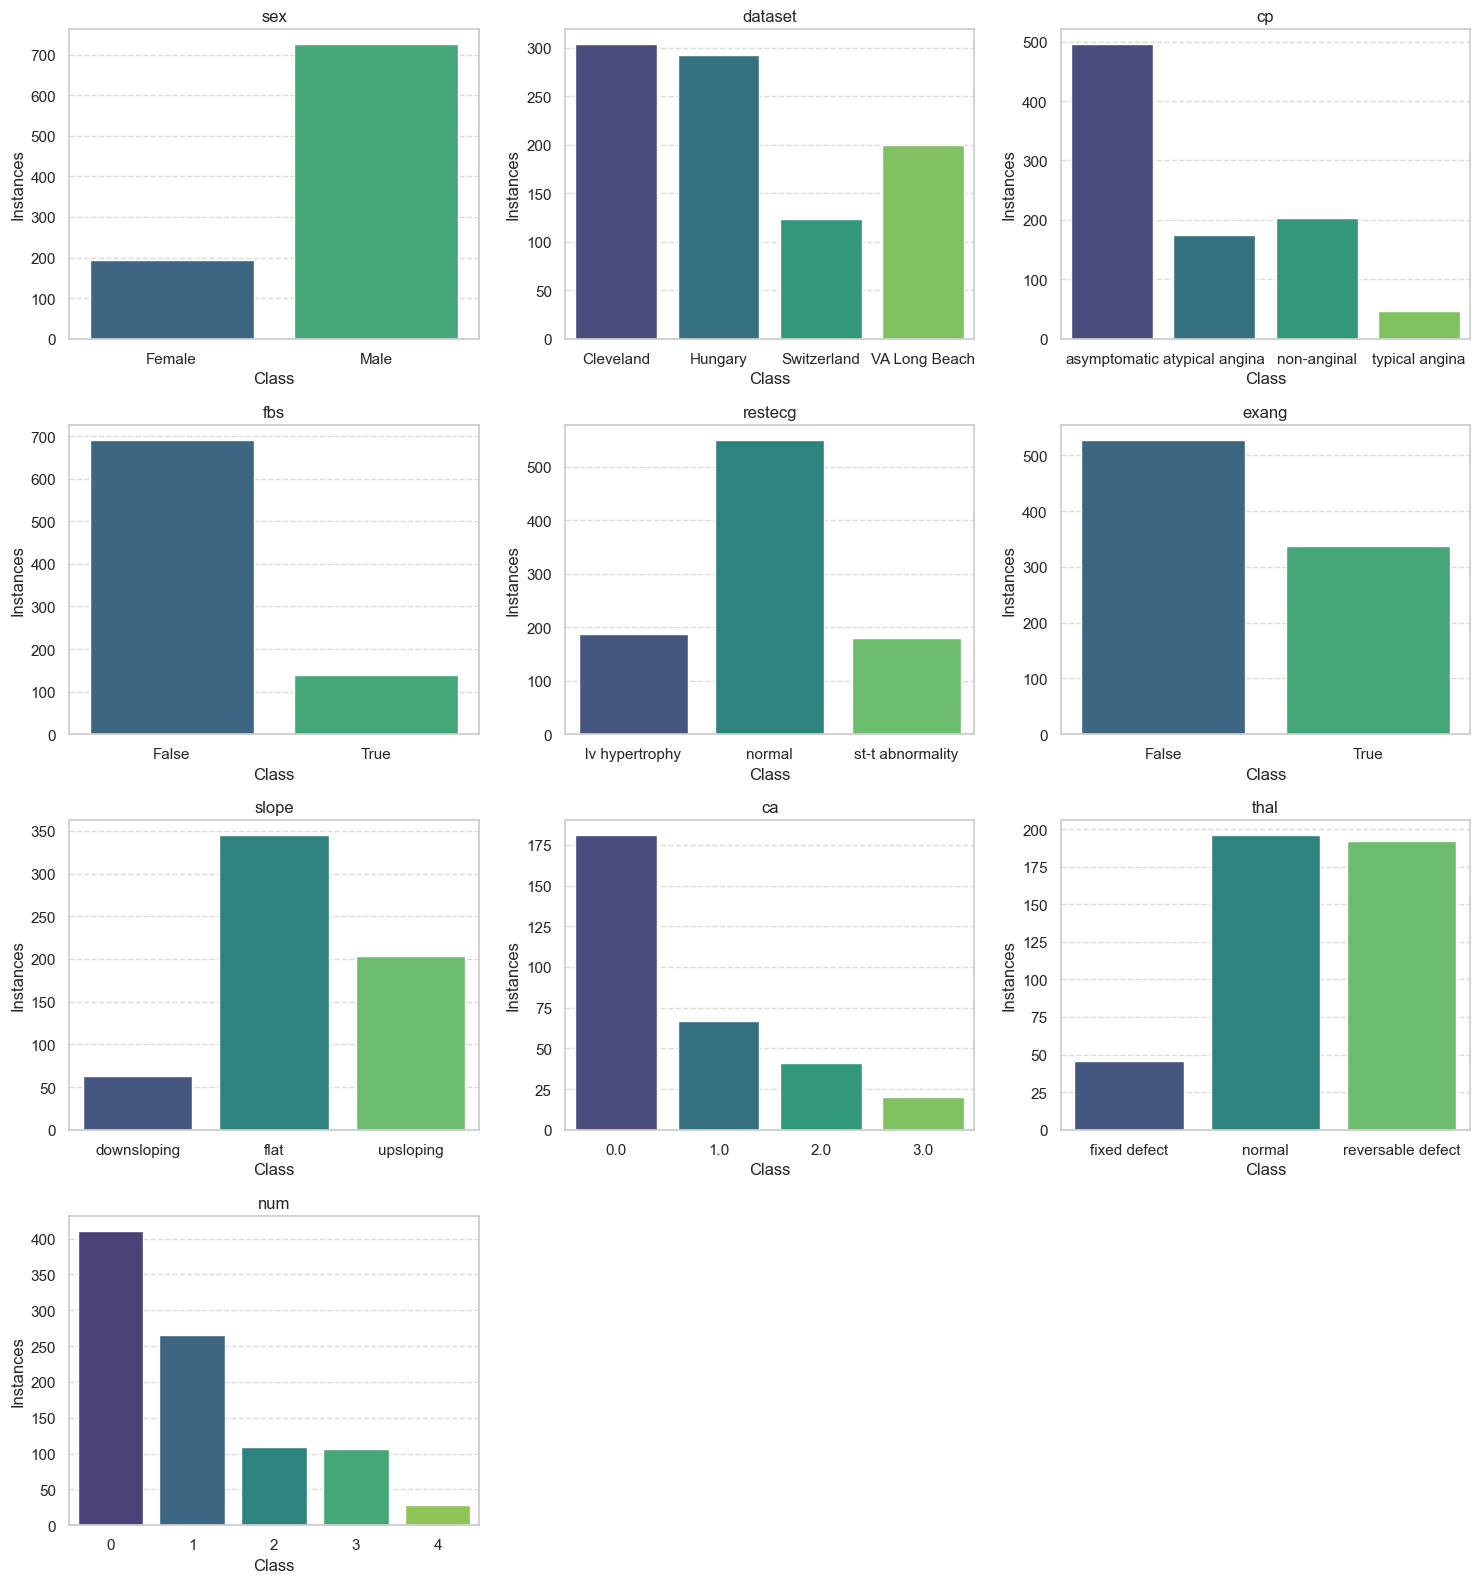

In [19]:
plot_class_distribution(df)

From class distribution plot and summary for 'sex' it was finally proven that male significantly dominate female on this dataset (male - 78.91%). Thus, it may be interesting to check if the performence of model will differ significantly by sex.

From the chest pain type 'cp' could be noticed that asymptomatic is the most common type. It is worth checking whether `cp` correlates with heart disease severity.

Distribiution of `Fbs` reveals that 83.37% have normal fasting blood sugar levels, thus it may not be a very predictive feature.

Around 60% of the patients have nornal `restecg` and it is fairly even spread between lv hypertrophy and st-t abnormality. This feature may prove to be useful, however it has to be cross-tabulated with disease presence `num`.

Excercise induced angina `exang` experiences almost 40%, thus by checking its correlation with `num`, it may turned out to be a useful feature.

`Slope` plot presents that the most patients have flat slopes (56.46%), which can indicate ischemia. Upsloping (33.22%) and downsloping (10.31%) were less common. This high proportion of flat slopes may be indicator of cardiovascular risk.

Number of major vessels `ca` plot reveals that 58.58% of patients have no major vessels affected (0.0). This feature could have be strong predictive feature, as `ca` is known for correlating with disease severity.

For thalassemia `thal` normal and reversable defect are balanced. However, the “reversible defect” (10.60%) is often a marker of stress-induced ischemia, which potentially can be a strong disease indicator.

For our target variable - Disease Severity or Presence `num` "No disease" constitute 44.67%. Different levels of heart disease severity are 55.33% in total. The target is imalanced - class balancing or stratified sampling in ML is necessary.

## After Data Cleaning
---

The dataset was cleaned using a custom pipeline.
- Identifier column (`id`) was dropped as it does not provide predictive value.
  
- Columns with more than 40% missing values were removed.
  
- Physiologically invalid values (e.g., chol < 40, oldpeak < 0) were replaced with NaN. Then, missing values were imputed using random values drawn from a normal distribution based on column mean and standard deviation.

- NaN values in categorical columns were imputed by adding a new "Missing" category.

- Outliers were capped in numeric columns using the IQR method (reduce the influence of extreme values).

In [20]:
df_clean = clean_dataframe(df)

### Shape and Size of Dataset

In [21]:
print("Shape:", df_clean.shape)
print("Records (rows):", df_clean.shape[0])
print("Features (columns):", df_clean.shape[1])

Shape: (920, 13)
Records (rows): 920
Features (columns): 13


Number of columns dropped from 16 → 13 after cleaning.

### Data Types

In [22]:
df_clean.dtypes

age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
num           int64
dtype: object

- In order to prepare the dataset for further processing `fbs` and `exang` were converted from object to bool.
  
- Object-type columns (`sex`, `dataset`, `cp`, `restecg`, `slope`) are categorical and require encoding during preprocessing.
  
- Numeric columns like `age`, `trestbps`, `chol`, `thalach`, `oldpeak`, and `num` are appropriate types (int64 or float64).

#### Categorical vs Numerical Columns

In [23]:
numerical_columns = df_clean.select_dtypes(include=np.number).columns.to_list()
categorical_columns = df_clean.select_dtypes(exclude=np.number).columns.to_list()

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)


Numerical columns: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'num']
Categorical columns: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope']


Categorical column count remained the same at 7, but `fbs` and `exang` were converted from object to bool (to prepare for later modeling).

##### Statistical Description of Numerical Columns 

In [24]:
df_clean[numerical_columns].describe()

age    trestbps        chol      thalch     oldpeak         num
count  920.000000  920.000000  920.000000  920.000000  920.000000  920.000000
mean    53.510870  131.916304  244.336957  137.766304    0.932935    0.995652
std      9.424685   17.324169   52.753678   25.822619    1.031860    1.142693
min     28.000000   90.000000  106.000000   64.500000    0.000000    0.000000
25%     47.000000  120.000000  208.000000  120.000000    0.000000    0.000000
50%     54.000000  130.000000  239.000000  140.000000    0.700000    1.000000
75%     60.000000  140.000000  276.000000  157.000000    1.600000    2.000000
max     77.000000  170.000000  378.000000  202.000000    4.000000    4.000000

- Row count is now consistent across all columns at 920. Columns like `trestbps`, `chol`, `thalch`, and `oldpeak` had missing values filled using the median strategy (for numeric types).

- Extreme values were capped using the IQR method.
  
- Physiologically invalid values (e.g. negative `oldpeak`, `chol` and `trestbps` = 0) were corrected.

- Outliers for everal columns, including chol, were capped (e.g., from 603 to 407.5).

- Standard deviation (e.g., in `chol`) decreased which indicates fewer extreme deviations.

##### Statistical Description of Categorical Columns 

In [25]:
if categorical_columns:
    display(df_clean[categorical_columns].describe())
else:
    print("No categorical columns to describe")

sex    dataset            cp    fbs restecg  exang slope
count    920        920           920    920     920    920   920
unique     2          4             4      3       4      3     4
top     Male  Cleveland  asymptomatic  False  normal  False  flat
freq     726        304           496    692     551    528   345

- Missing values in were imputed by adding a new "Missing" category.
  
- Most frequent values remained consistent, which confirms no skew introduced by filling.

### Index vs Numerical Columns
 

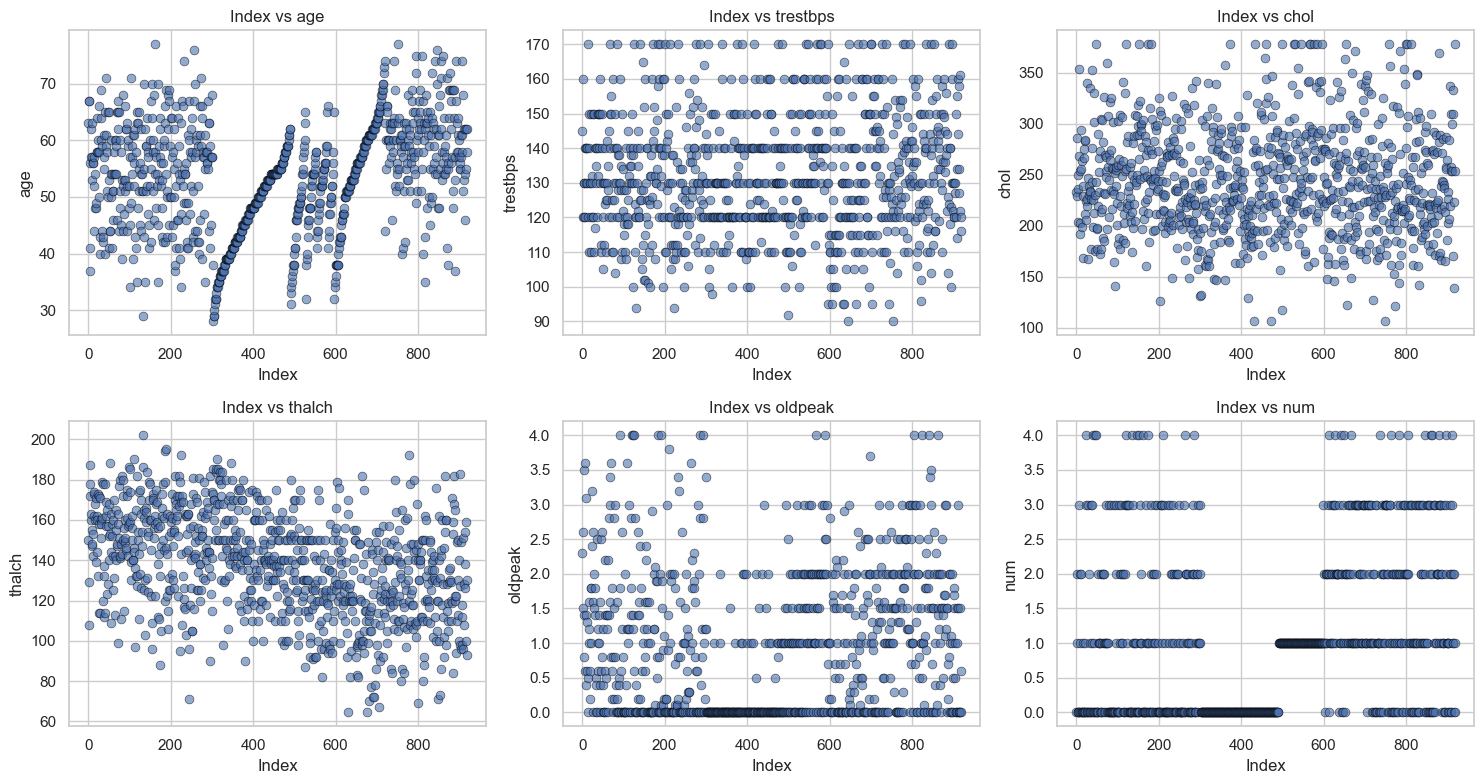

In [26]:
plot_index_column_relation(df_clean)

- Distributions for variables such as `chol`, `oldpeak`, and `trestbps` now appear more compact, with extreme outliers trimmed.

- Negative `oldpeak` values and implausibly low `chol` have been fully removed from the scatter patterns.

- Variables like `thalach` and `chol` present smoother distributions without abrupt gaps or isolated extreme spikes.

### Skewness Analysis

In [27]:
calculate_skewness(df_clean)

Feature  Skewness                Skew Type
0       num  0.968880             Right-skewed
1   oldpeak  0.919832             Right-skewed
2      chol  0.375276  Approximately symmetric
3  trestbps  0.286607  Approximately symmetric
4    thalch -0.214856  Approximately symmetric
5       age -0.195994  Approximately symmetric

- For `chol` and `oldpeak` reduction in skewness can be noticed. 
  - `chol` shifted from left-skewed (-0.61) to approximately symmetric (0.38), whcih corresponds to removal of extreme low values and outlier capping
  - `oldpeak` shows slight reduction in right skew (from 1.04 to 0.92), likely due to elimination of negative values and high-end outliers.

- For other features we have stable distributions.
  - `trestbps`, `thalch`, and `age` remained approximately symmetric with minimal changes in skewness.

- As expected for a discrete outcome, target variable `num` retained the same right-skewed distribution (unchanged at 0.968).

### Violin Plots of Numerical Features

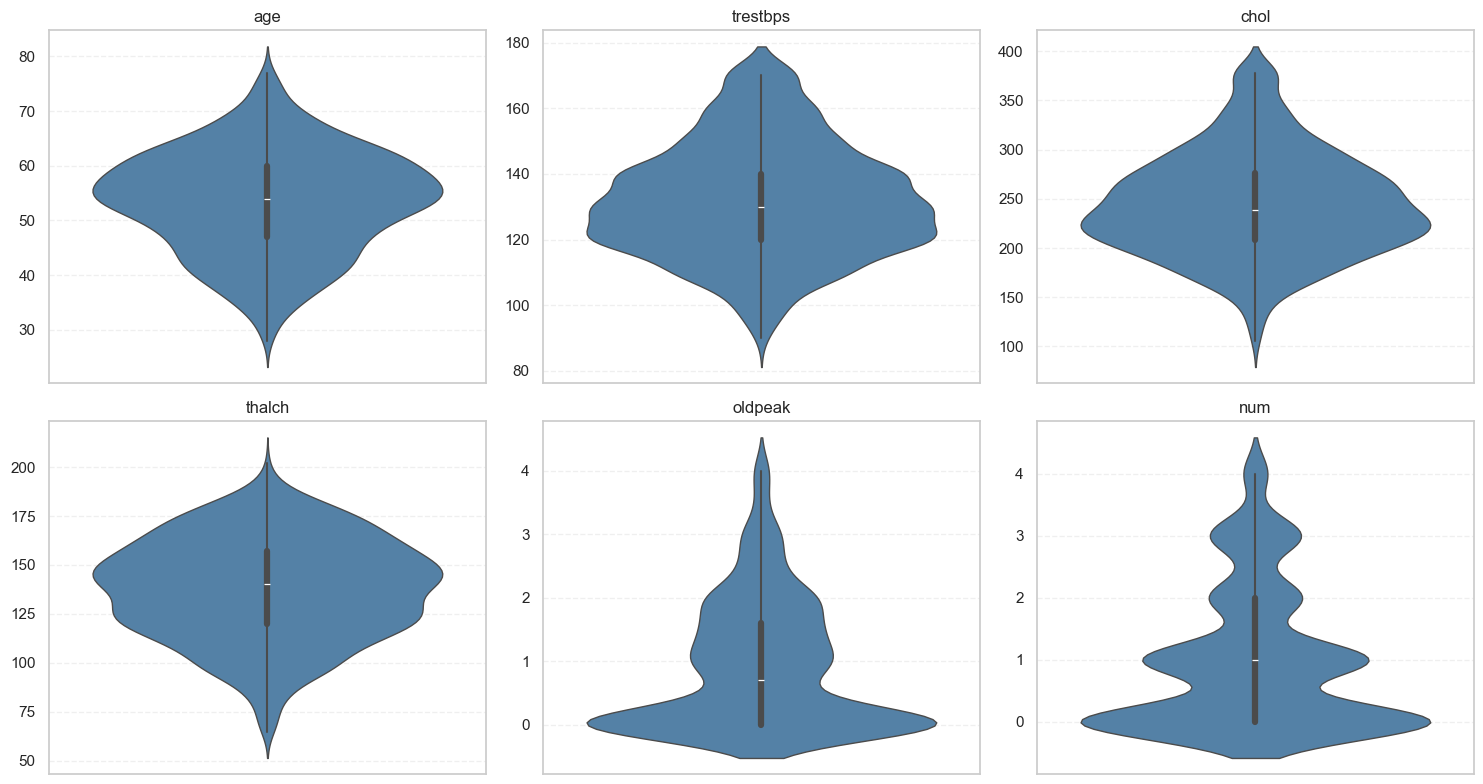

In [28]:
plot_violins(df_clean)

Plots show reduced influence of extreme values, removal of physiologically impossible results, and better alignment of feature distributions.

### Histogram Frequency

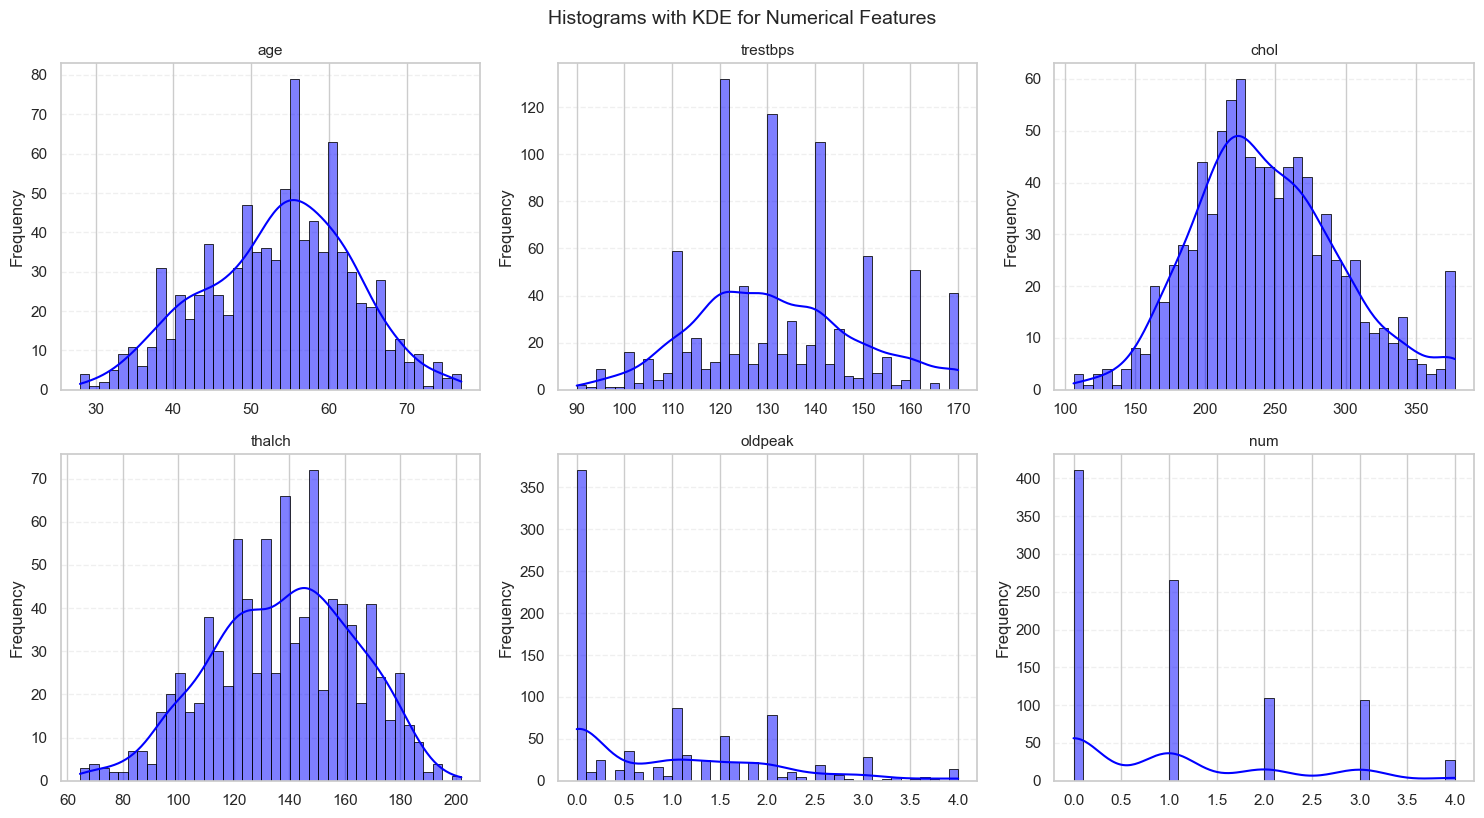

In [29]:
plot_histograms_with_kde(df_clean)

- Histogrmas for features such like `chol` and `trestbps` are now  more symmetric.

- Highly skewed `oldpeak` display reduced extreme tails, making them more concentrated around typical ranges.

- KDE curves are now smoother, with fewer sharp spikes. This indicates that extreme anomalies were handled and replaced with values consistent with the main distribution.

- While extreme outliers were capped, the cleaning process retained the general spread and patterns of the data and avoided over-smoothing.

### Correlation of Columns

#### Correlation Heatmap

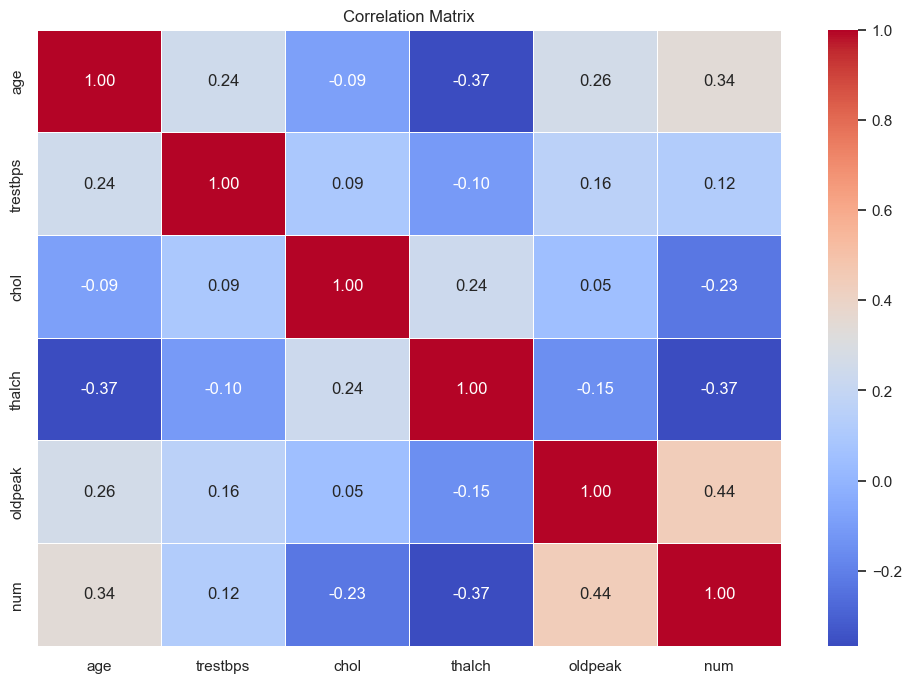

In [30]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_columns].corr(), annot=True, linewidth=.5, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

Correlation structure was preserved. Matrix now focuses solely on relevant variables.

In [31]:
df.corr(numeric_only=True)

id       age  trestbps      chol    thalch   oldpeak  \
id        1.000000  0.239301  0.052924 -0.376936 -0.466427  0.049930   
age       0.239301  1.000000  0.244253 -0.086234 -0.365778  0.258243   
trestbps  0.052924  0.244253  1.000000  0.092853 -0.104899  0.161908   
chol     -0.376936 -0.086234  0.092853  1.000000  0.236121  0.047734   
thalch   -0.466427 -0.365778 -0.104899  0.236121  1.000000 -0.151174   
oldpeak   0.049930  0.258243  0.161908  0.047734 -0.151174  1.000000   
ca        0.061433  0.370416  0.093705  0.051606 -0.264094  0.281817   
num       0.273552  0.339596  0.122291 -0.231547 -0.366265  0.443084   

                ca       num  
id        0.061433  0.273552  
age       0.370416  0.339596  
trestbps  0.093705  0.122291  
chol      0.051606 -0.231547  
thalch   -0.264094 -0.366265  
oldpeak   0.281817  0.443084  
ca        1.000000  0.516216  
num       0.516216  1.000000

Once again no change in correlation coefficients is confirmed – before and after matrices are identical.

Cleaning was non-disruptive to structure – operations like invalid value replacement, imputation, and outlier capping did not distort correlations.

### Unique Values

In [32]:
print_unique_values(df_clean)


Column: age
[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
age: 50 unique values

Column: trestbps
[90.0, 92.0, 94.0, 95.0, 96.0, 98.0, 100.0, 101.0, 102.0, 104.0, 105.0, 106.0, 107.0, 108.0, 110.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 152.0, 154.0, 155.0, 156.0, 158.0, 160.0, 161.0, 164.0, 165.0, 170.0]
trestbps: 62 unique values

Column: chol
[106.0, 117.0, 121.0, 122.0, 126.0, 127.0, 129.0, 131.0, 132.0, 139.0, 141.0, 142.0, 144.0, 146.0, 147.0, 148.0, 149.0, 153.0, 156.0, 157.0, 160.0, 161.0, 162.0, 163.0, 164.0, 165.0, 166.0, 167.0, 168.0, 169.0, 170.0, 171.0, 172.0, 173.0, 174.0, 175.0, 176.0, 177.0, 178.0, 17

- By eliminating extreme low and high outliers, `trestbps` range was tightened. The count of unique values slightly increased (61 → 62).

- `chol` kept the same number of unique values (217) but with biologically realistic minimum values.

- `oldpeak` reduced from 53 → 38 unique values due to removal of negative and implausible entries.

- Categorical columns with explicit missing labels – `fbs`, `restecg`, `exang`, and `slope` gained an additional "Missing" category to handle NaN values explicitlly.

### Pairplot with Hue

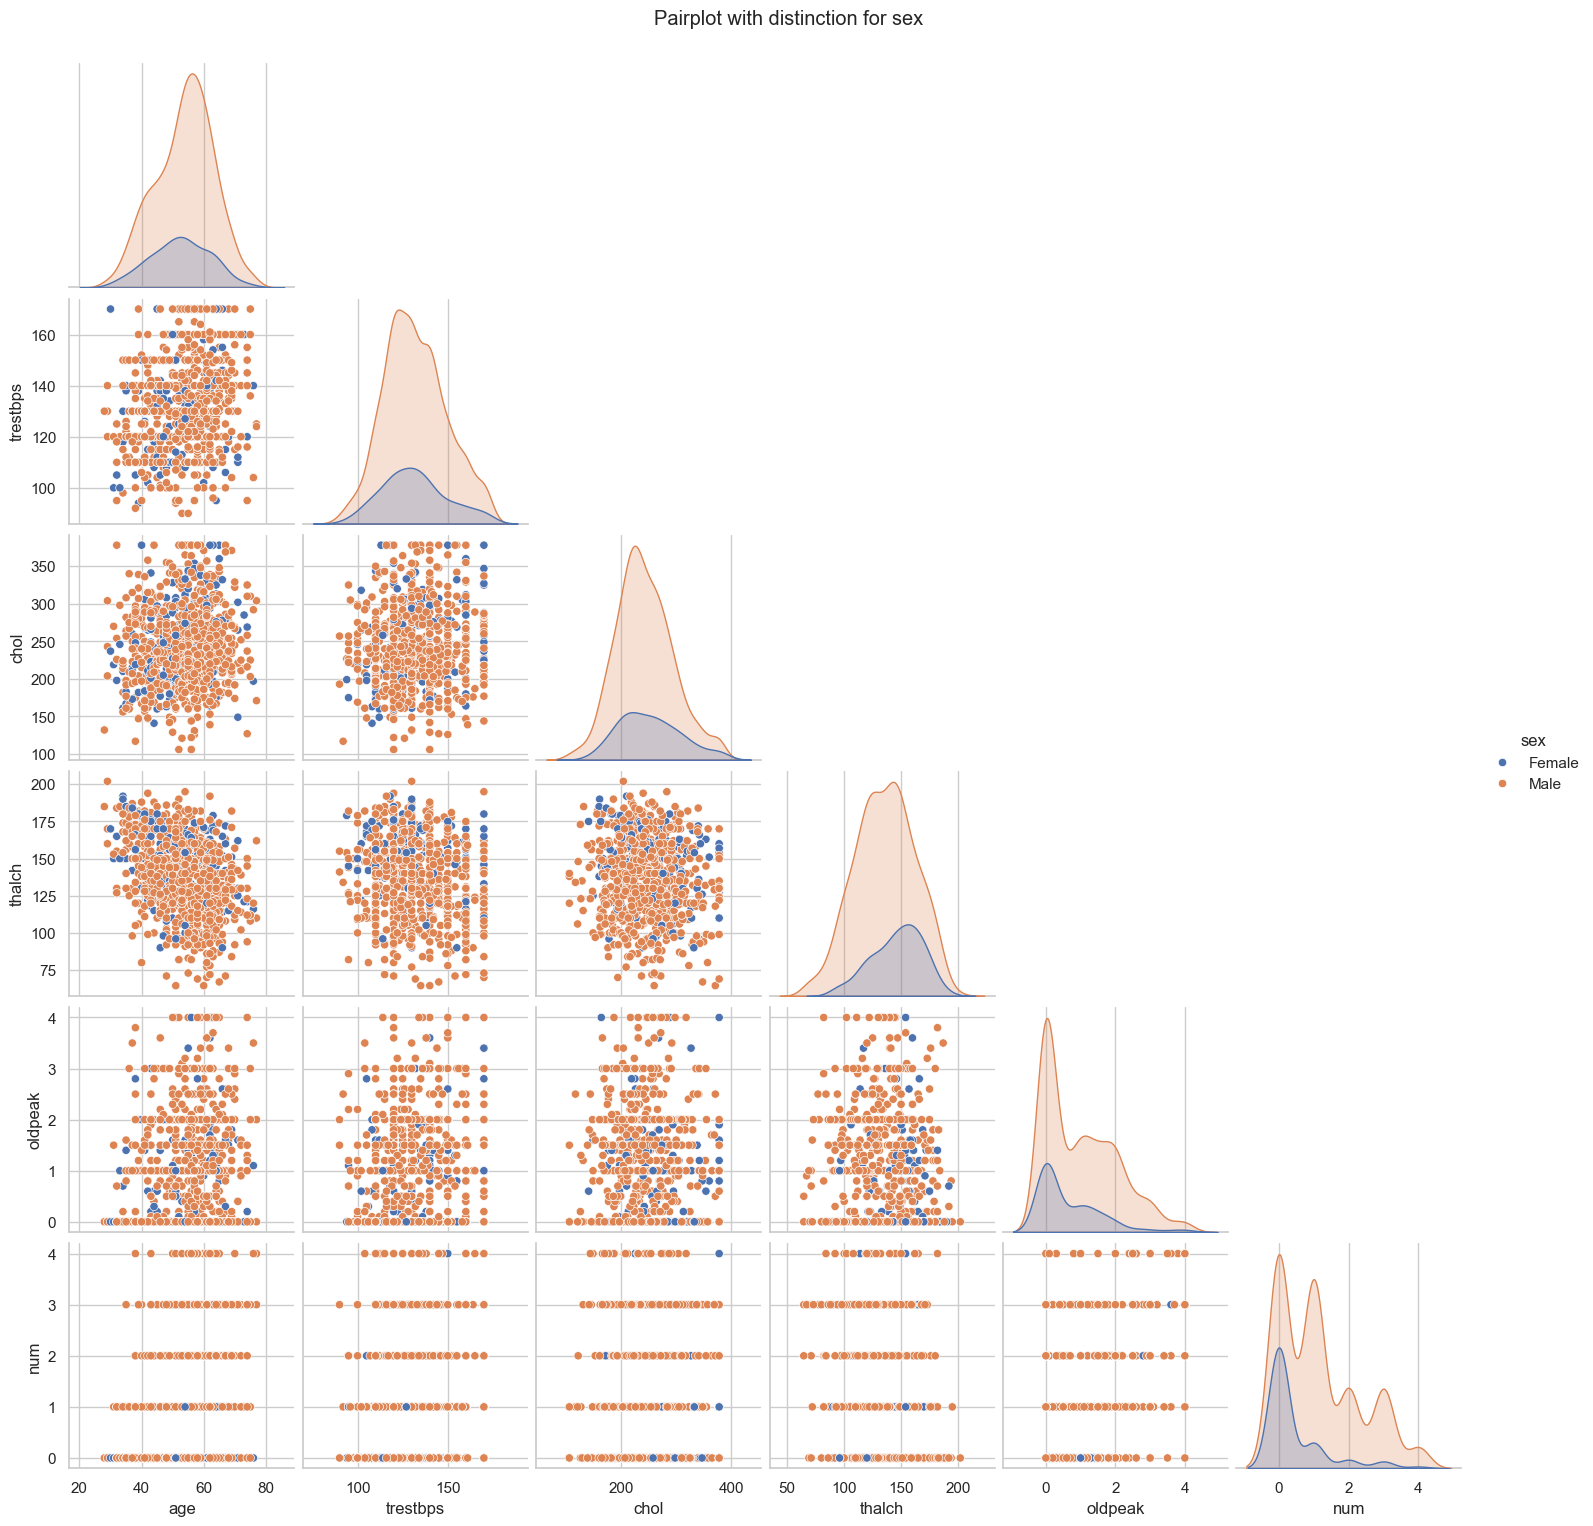

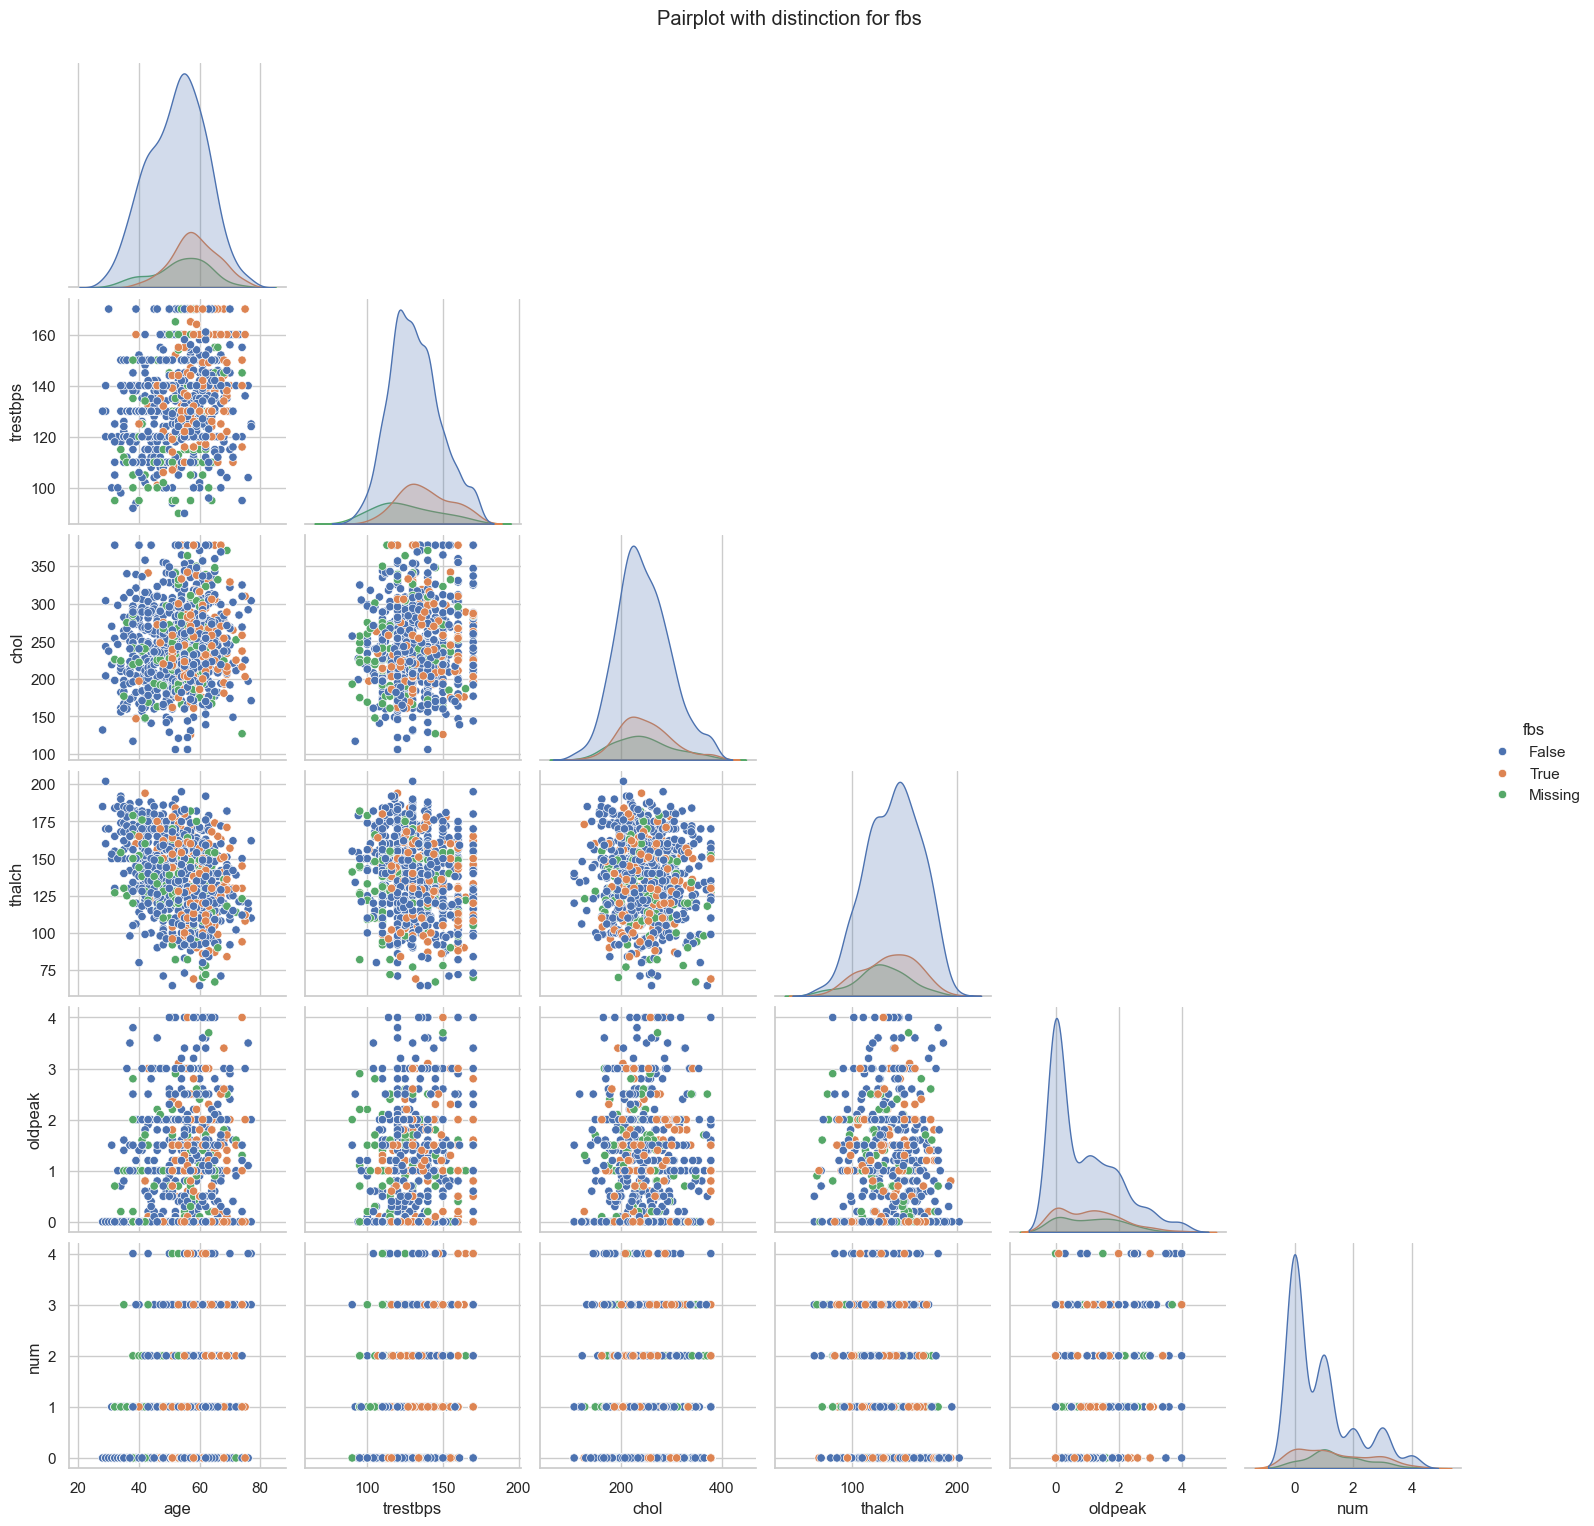

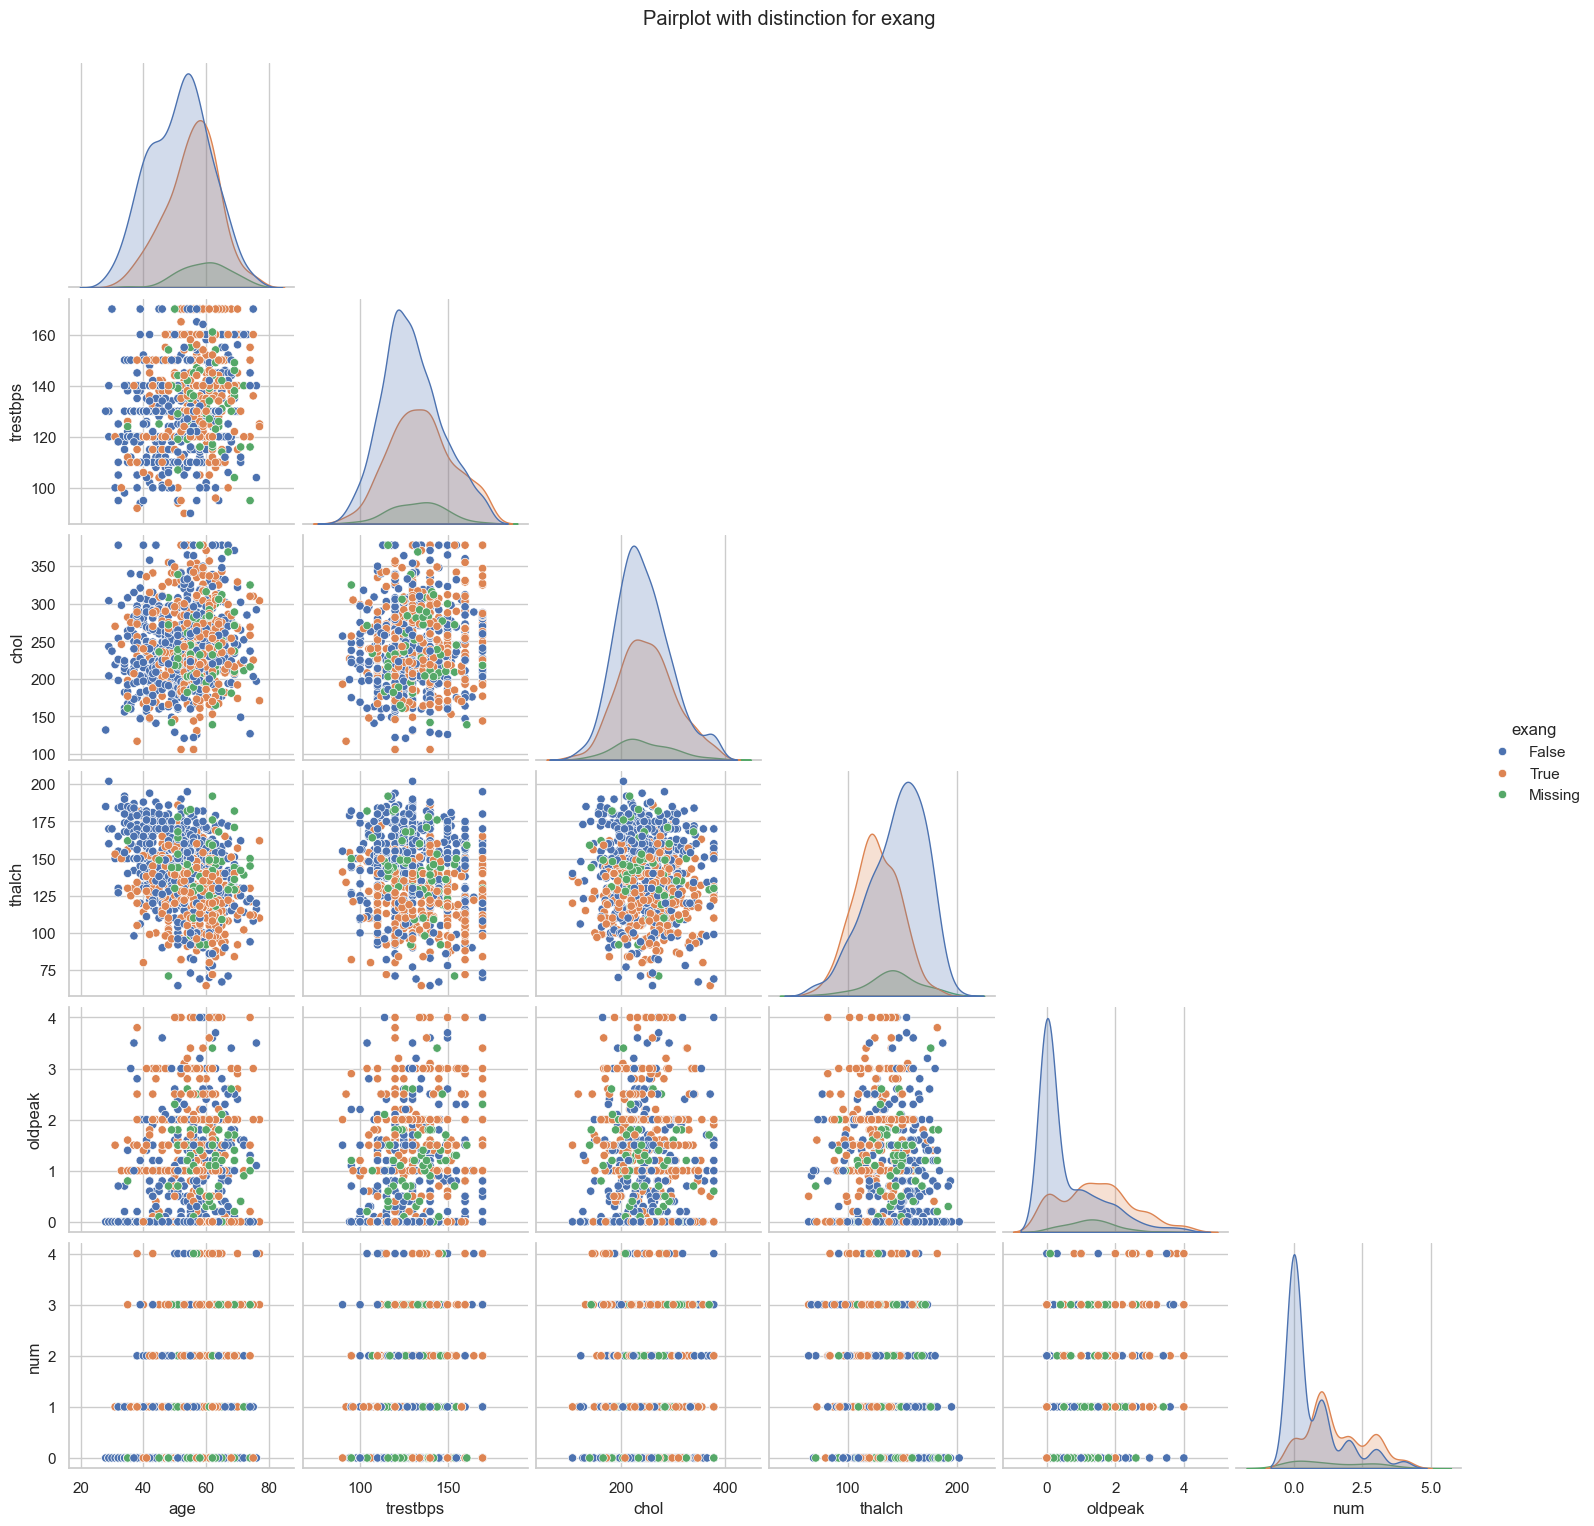

In [33]:
plot_pairplot_with_hue(df_clean, hue_col='sex')
plot_pairplot_with_hue(df_clean, hue_col='fbs')
plot_pairplot_with_hue(df_clean, hue_col='exang')

Pairplots shows smoothed the data clouds after capping outliers and imputing. Diagonal KDE plots show better defined peaks as a result of invalid values removal.

Pairplots by `fbs` and by `exang` introduces explicitly "Missing" category.

Relationships between distincted categories remain consistent, indicating that cleaning did not distort genuine associations.

### Mutual Information Score

Feature  Mutual Information
0   oldpeak            0.112226
1    thalch            0.074191
2       age            0.052379
3      chol            0.014301
4  trestbps            0.006308

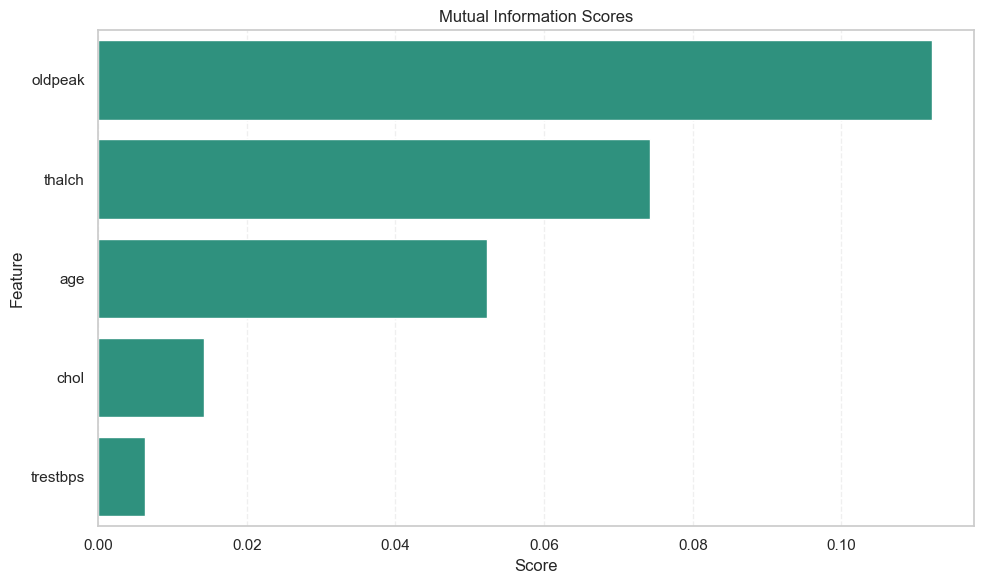

In [34]:
mi_df = compute_mutual_info(df_clean, target_column='num')
display(mi_df)
plot_mutual_info(mi_df)

Now `age` gained measurable importance (0.052), likely due to more coherent distributions and removal of inconsistent data.

Features like `trestbps` and `chol` show slightly lower mutual information after cleaning. It proves that false correlations caused by extreme or invalid values were removed.

### Class Label Distribiution 


Class Distribution Summary for 'sex':
| Class   |   Instances |   Percentage |
|:--------|------------:|-------------:|
| Female  |         194 |        21.09 |
| Male    |         726 |        78.91 |

Class Distribution Summary for 'dataset':
| Class         |   Instances |   Percentage |
|:--------------|------------:|-------------:|
| Cleveland     |         304 |        33.04 |
| Hungary       |         293 |        31.85 |
| Switzerland   |         123 |        13.37 |
| VA Long Beach |         200 |        21.74 |

Class Distribution Summary for 'cp':
| Class           |   Instances |   Percentage |
|:----------------|------------:|-------------:|
| asymptomatic    |         496 |        53.91 |
| atypical angina |         174 |        18.91 |
| non-anginal     |         204 |        22.17 |
| typical angina  |          46 |         5.00 |

Class Distribution Summary for 'fbs':
| Class   |   Instances |   Percentage |
|:--------|------------:|-------------:|
| False   |        

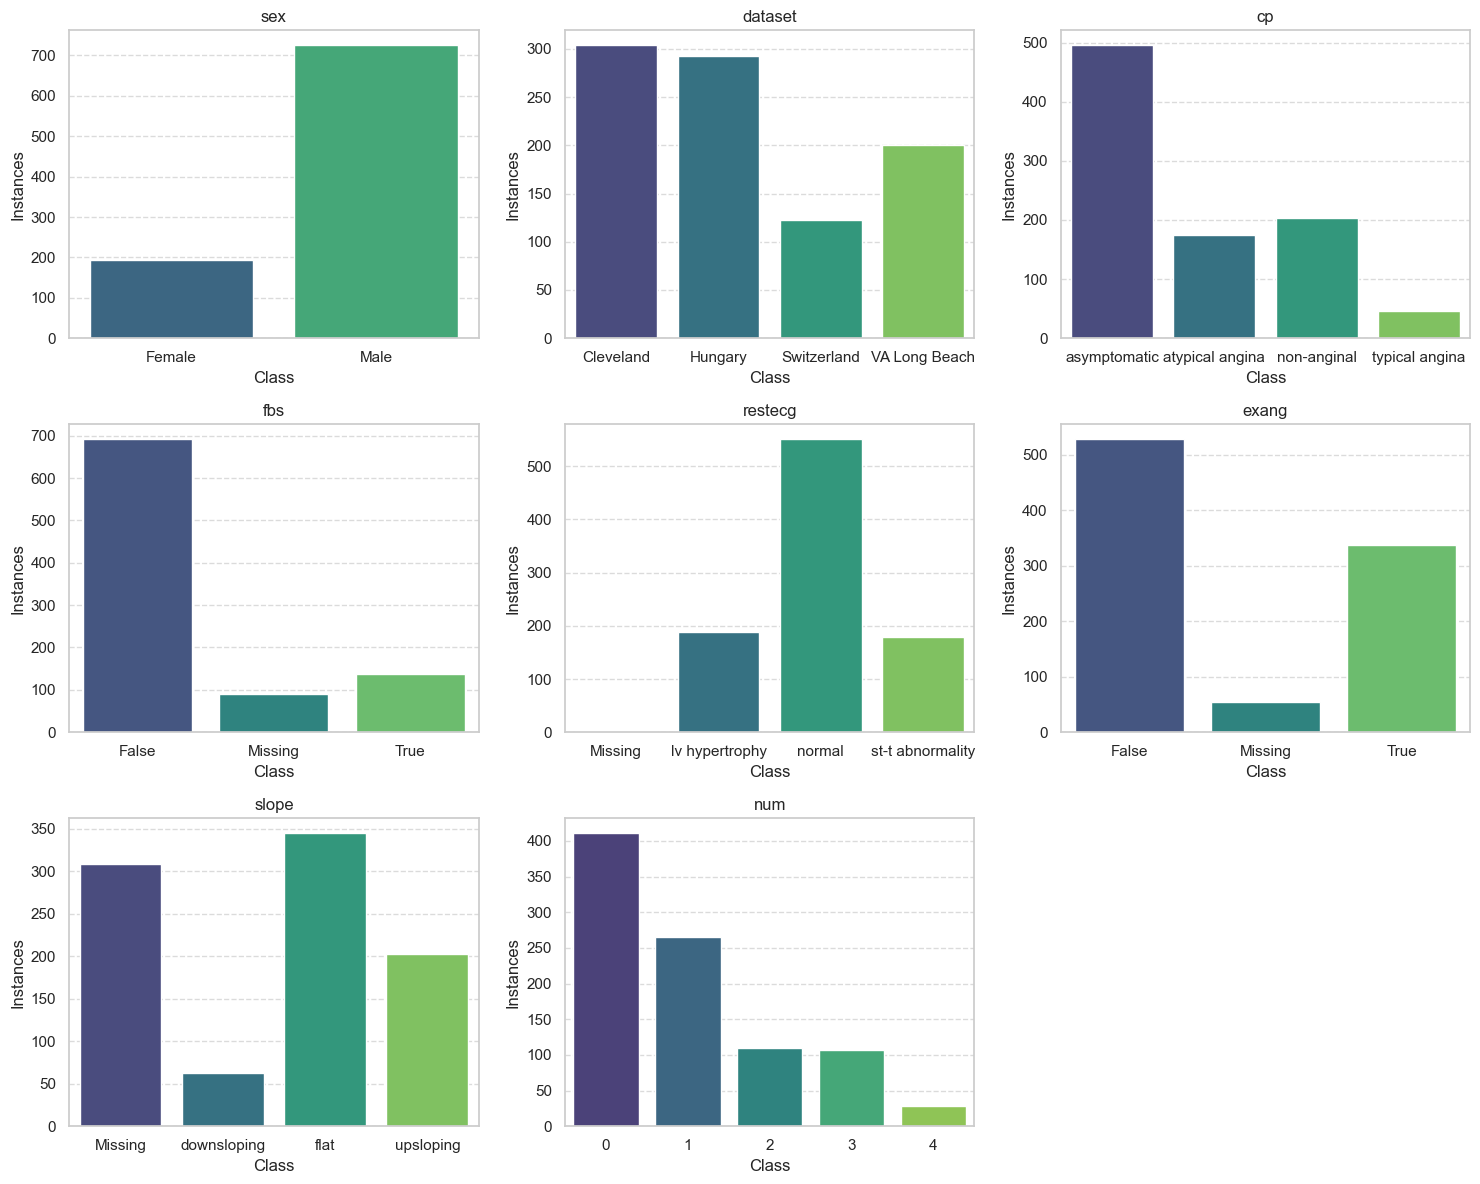

In [35]:
plot_class_distribution(df_clean)

Distributions for `sex`, `dataset`, `cp`, and `num` remained identical.

`fbs`: "False" proportion decreased (83.37% → 75.22%) as missing values (9.78%) were made explicit.

`restecg`: "Missing" (0.22%), other categories remain virtually unchanged.

`exang`: "False" slightly reduced (61.04% → 57.39%), "Missing" introduced (5.98%).

`slope`: major shift with "Missing" introduced (33.59%), reducing counts for "flat" and "upsloping" compared to before cleaning.